In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib as mpl
from matplotlib.patches import Patch
import scienceplots
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm
from scipy.spatial.distance import jensenshannon
# import pymc as pm
# import aesara.tensor as at
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# import arviz as az
# import pytensor.tensor as at

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

COLORS = ["#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6"]
MARKERS = ["o", "^", "s", "P", "o", "X", "^", "v"]
LINESTYLES = ["solid", "dashed", "dashdot", "dotted"]

mpl.rcParams["hatch.linewidth"] = 0.7
mpl.rcParams.update(mpl.rcParamsDefault)


# Main Analysis: Preprocess Data

In [2]:
ball_comp = {(2,2):{'p_col1_u1':0.7, 'p_col2_u1':0.3, 'p_col1_u2':0.3, 'p_col2_u2':0.7}, 
             (2,3):{'p_col1_u1':0.7, 'p_col2_u1':0.2, 'p_col3_u1':0.1, 'p_col1_u2':0.2, 'p_col2_u2':0.1, 'p_col3_u2':0.7},
             (2,4):{'p_col1_u1':0.4, 'p_col2_u1':0.3, 'p_col3_u1':0.2, 'p_col4_u1':0.1, 'p_col1_u2':0.1, 'p_col2_u2':0.2, 'p_col3_u2':0.3, 'p_col4_u2':0.4},
             (3,2):{'p_col1_u1':0.7, 'p_col2_u1':0.3, 'p_col1_u2':0.5, 'p_col2_u2':0.5, 'p_col1_u3':0.3, 'p_col2_u3':0.7},
             (3,3):{'p_col1_u1':0.7, 'p_col2_u1':0.2, 'p_col3_u1':0.1, 'p_col1_u2':0.1, 'p_col2_u2':0.7, 'p_col3_u2':0.2, 'p_col1_u3':0.2, 'p_col2_u3':0.1, 'p_col3_u3':0.7},
             (3,4):{'p_col1_u1':0.4, 'p_col2_u1':0.3, 'p_col3_u1':0.2, 'p_col4_u1':0.1, 'p_col1_u2':0.3, 'p_col2_u2':0.2, 'p_col3_u2':0.2, 'p_col4_u2':0.3, 'p_col1_u3':0.1, 'p_col2_u3':0.2, 'p_col3_u3':0.3, 'p_col4_u3':0.4},
             (4,2):{'p_col1_u1':0.7, 'p_col2_u1':0.3, 'p_col1_u2':0.6, 'p_col2_u2':0.4, 'p_col1_u3':0.4, 'p_col2_u3':0.6, 'p_col1_u4':0.3, 'p_col2_u4':0.7},
             (4,3):{'p_col1_u1':0.7, 'p_col2_u1':0.2, 'p_col3_u1':0.1, 'p_col1_u2':0.1, 'p_col2_u2':0.7, 'p_col3_u2':0.2, 'p_col1_u3':0.2, 'p_col2_u3':0.1, 'p_col3_u3':0.7, 'p_col1_u4':0.3, 'p_col2_u4':0.4, 'p_col3_u4':0.3},
             (4,4):{'p_col1_u1':0.4, 'p_col2_u1':0.3, 'p_col3_u1':0.2, 'p_col4_u1':0.1, 'p_col1_u2':0.3, 'p_col2_u2':0.4, 'p_col3_u2':0.1, 'p_col4_u2':0.2, 'p_col1_u3':0.2, 'p_col2_u3':0.1, 'p_col3_u3':0.4, 'p_col4_u3':0.3, 'p_col1_u4':0.1, 'p_col2_u4':0.2, 'p_col3_u4':0.3, 'p_col4_u4':0.4}
}

## Read Data

In [3]:
def read_participant_data(filePath, min_pID, max_pID, insList):
    ''''
    Reads participant data main experiment data from JSON files and combines them into a single DataFrame.
    '''
    participantsWithData = []
    for pID in range(min_pID, max_pID+1):
        completed = True
        for instance_name in insList:
            try:
                with open(filePath + f'participantData{pID}/p{pID}BU{instance_name}.json') as f:
                    data = json.load(f)
                    df = pd.json_normalize(data)
                    if 'participant_data' not in locals():
                        participant_data = df
                    else:
                        participant_data = pd.concat([participant_data, df], ignore_index=True)
                
            except FileNotFoundError:
                completed = False
                
        if completed:
            participantsWithData.append(pID)

    print(f'Participants with complete data: {participantsWithData}')
    incomplete_data_participants = [pID for pID in participant_data["participantID"].unique() if int(pID) not in participantsWithData]
    print(f'Participants with incomplete data: {incomplete_data_participants}')
    return participant_data, incomplete_data_participants

In [4]:
# Read participant data from json
min_pID = 1
max_pID = 20
insList = [1,3,5,7,9,11,12,13,15,16,17,18]
filePath = '../participantData/'

participant_data, incomplete_lis = read_participant_data(filePath, min_pID, max_pID, insList)

Participants with complete data: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Participants with incomplete data: []


### Eliminate all imcomplete data

In [5]:
participant_data = participant_data[~participant_data['participantID'].isin(incomplete_lis)]
participant_data['participantID'] = participant_data['participantID'].astype(int)

### Read the Demographic Data - Combine with main data

In [6]:
def read_demographic_data(filePath, min_pID, max_pID):
    '''
    Reads demographic data from CSV files and combines them into a single DataFrame.
    '''
    demo_df = pd.DataFrame()
    for pID in range(min_pID, max_pID+1):
        try:
            df = pd.read_csv(filePath + f'participantData{pID}/demographicData/p{pID}.csv')
            demo_df = pd.concat([demo_df, df[['participantID','payID','fullName','age','sex','probSubject','bayesFamaliar','bayesInExp']]], ignore_index=True)
        except FileNotFoundError:
            print(f'File not found for participant {pID}')

    return demo_df

# Read demographic data from csv
demo_df = read_demographic_data(filePath, min_pID, max_pID)
demo_df['participantID'] = demo_df['participantID'].astype(int)
demo_df

File not found for participant 3


,participantID,payID,fullName,age,sex,probSubject,bayesFamaliar,bayesInExp
0,1,466625762,Aditi Verma,18,Female,No,Yes,Never
1,2,459918142,Ajeng Septiarini,31,Female,No,No,Never
2,4,pusheen2611@gmail.com,Angela Suhendra,19,Female,No,No,Not Applicable
3,5,451545805,Ariza Aulia Ghifari,22,Male,Yes,No,Never
4,6,434100809,Belly Munandar,32,Male,No,No,Not Applicable
5,7,diahpratiwi1201@gmail.com,Diah Pratiwi,32,Female,No,No,Never
6,8,414310039,Dyah Gayatri Wulandari,34,Female,Yes,No,Not Applicable
7,9,447483632,Guntur Novfrico Prasetya,34,Male,Yes,No,Not Applicable
8,10,493892398,Haihan Ni,23,Female,No,No,Not Applicable
9,11,425411010,Jhil Mehta,22,Female,No,Yes,Sometimes


In [7]:
participant_data = pd.merge(participant_data, demo_df, on='participantID', how='left')
participant_data

,participantID,instanceName,seqBall,urnPosteriors,colourPosteriors,responseTimeUrn,responseTimeColour,payID,fullName,age,sex,probSubject,bayesFamaliar,bayesInExp
0,1,BU1,1,"[30.0, 70.0]","[45.0, 55.0]",22.43,11.40,466625762,Aditi Verma,18,Female,No,Yes,Never
1,1,BU1,2,"[70.0, 30.0]","[55.0, 45.0]",10.50,10.10,466625762,Aditi Verma,18,Female,No,Yes,Never
2,1,BU1,3,"[30.0, 70.0]","[45.0, 55.0]",7.27,13.47,466625762,Aditi Verma,18,Female,No,Yes,Never
3,1,BU3,1,"[80.0, 20.0]","[42.0, 21.0, 37.0]",38.32,53.75,466625762,Aditi Verma,18,Female,No,Yes,Never
4,1,BU3,2,"[85.0, 15.0]","[51.0, 12.0, 37.0]",37.48,29.02,466625762,Aditi Verma,18,Female,No,Yes,Never
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,20,BU17,2,"[20.0, 30.0, 20.0, 30.0]","[24.0, 26.0, 24.0, 26.0]",192.43,224.25,402164170,Zixin Liu,20,Female,No,Yes,Never
680,20,BU17,3,"[16.0, 24.0, 26.0, 34.0]","[22.0, 24.0, 26.0, 28.0]",112.08,90.70,402164170,Zixin Liu,20,Female,No,Yes,Never
681,20,BU18,1,"[10.0, 20.0, 30.0, 40.0]","[20.0, 21.0, 30.0, 29.0]",303.47,104.55,402164170,Zixin Liu,20,Female,No,Yes,Never
682,20,BU18,2,"[12.0, 18.0, 35.0, 35.0]","[15.0, 25.0, 30.0, 30.0]",38.98,39.88,402164170,Zixin Liu,20,Female,No,Yes,Never


## Disaggregate Posteriors

In [8]:
def disaggregatePosteriors(participant_data, urn_names, col_names):
    for idx, row in participant_data.iterrows():
        for i in range(len(row['urnPosteriors'])):
            participant_data.at[idx, urn_names[i]+'_r'] = row['urnPosteriors'][i]
    
        for j in range(len(row['colourPosteriors'])):
            participant_data.at[idx, col_names[j]+'_r'] = row['colourPosteriors'][j]
            

In [9]:
max_urns = 4
max_colours = 4
urn_names = ['uA', 'uB', 'uC', 'uD']
col_names = ['cB', 'cW', 'cP', 'cG']

disaggregatePosteriors(participant_data, urn_names, col_names)

## Reproduce the number of urns and number of colours

In [10]:
participant_data['urns'] = participant_data['urnPosteriors'].apply(lambda x: len(x))
participant_data['colours'] = participant_data['colourPosteriors'].apply(lambda x: len(x))

## Read Correct Answer from File

Note: Need to change the file in the working directory if the input file is changed for my experiment

In [11]:
def read_correctAnswers():
    with open('obj_posteriors.json') as f:
        correctAnswers = json.load(f)
        return correctAnswers
    
correctAnswers = read_correctAnswers()

## Add Correct Probabilities to the df

In [12]:
def addCorrectAnswers(participant_data, urn_names, col_names):
    for idx, row in participant_data.iterrows():
        for i in range(len(row['urnPosteriors'])):
            participant_data.at[idx, urn_names[i]+'_c'] = correctAnswers[row['instanceName']][f'posterior_u{i+1}_draw{row["seqBall"]}'] *100
    
        for j in range(len(row['colourPosteriors'])):
            participant_data.at[idx, col_names[j]+'_c'] = correctAnswers[row['instanceName']][f'posterior_col{j+1}_draw{row["seqBall"]}'] *100

addCorrectAnswers(participant_data, urn_names, col_names)

## Calculate Step-wise Bayesian Posteriors

### Get the last reported posterior

In [13]:
participant_data['urnPosteriors-1'] = participant_data['urnPosteriors'].shift(1)

In [14]:
def bayesian_Updating_Urns_StepWise(num_urns, num_col, seqBall, ball_draws, prior, ball_comp = dict()):
    '''
    num_urns: number of urns in the experiment
    num_cols: number of ball colours in the experiment
    seqBall: number of sequential ball draws
    ball_draws: a list of ball draw event outcomes. e.g. ['col1','col2']
    prior: a list of the reported posterior from the previous draw e.g.[45.0, 55.0]	
    ball_comp: a dictionary of ball compositions in each urn. Key: (num_urns, num_cols), Values: a dictionary with keys being name of the conditional probability (e.g.p_col1_u1 probability of colour = 1 conditional on urn = 1) values being conditional probability
    output: a rounded (2 decimal points) dictionary of posterior
    '''
    assert type(num_urns) == int, "num_urns must be integer"
    assert type(num_col) == int, "num_col must be integer"
    assert type(ball_comp) == dict, "ball_comp must be a pre-defined dictionary of ball compositions"

    # initialize priors

    if seqBall == 1:
        prior_dict = {}
        for urn in range(1, num_urns+1):
            prior_dict[f"prior_u{urn}"] = 1/num_urns
    else:
        prior_dict = {}
        for urn in range(1, num_urns+1):
            prior_dict[f"prior_u{urn}"] = prior[urn-1]/100    

    # get ball composition probabilities - Likelihood
    relevant_p = ball_comp[(num_urns,num_col)]

    # Sequential Ball Draws using Bayesian Updating
    evidence_dict = {}
    for col in range(1, num_col+1):
        sum = 0
        for urn in range(1, num_urns+1):
            sum += prior_dict[f"prior_u{urn}"] * relevant_p[f"p_col{col}_u{urn}"]

        evidence_dict[f"p_col{col}"] = sum
    # calculate posterior
    posterior_dict = {}
    event =  ball_draws[seqBall-1]
    for urn in range(1, num_urns+1):
        posterior_dict[f"u{urn}"] = (prior_dict[f"prior_u{urn}"] * relevant_p[f"p_{event}_u{urn}"]) / evidence_dict[f"p_{event}"]


    rounded_dict = {key: round(value, 2) for key, value in posterior_dict.items()}    


    return rounded_dict

### Get ball draw events from input

In [15]:
# read JSON input file
filename = 'input.json'
with open(filename) as json_file:
    data = json.load(json_file)

# calculate posteriors for all instances
name_cols = ['B','W','P','G']
data_list = []

for instance in data:
    # key is 'BU1', value is a dictionary of urn info: urnName, prior, composition, balls, chosenUrn, ballDraws
    for key, value in instance.items():
        ball_draws = value['ballDraws']

        # Create a dictionary that maps each color name to "col1", "col2", etc.
        color_mapping = {color: f"col{i+1}" for i, color in enumerate(name_cols)}
        # Map each color in color_list to its corresponding label
        mapped_ball_draws = [color_mapping[color] for color in ball_draws]
        
        # Append to data list
        data_list.append({'instanceName': key, 'ballDrawCol': mapped_ball_draws})

# Create dataframe
ballDrawCol_df = pd.DataFrame(data_list)

participant_data = pd.merge(participant_data, ballDrawCol_df, on='instanceName')


In [16]:
participant_data['urnPosSW'] = participant_data.apply(lambda x: bayesian_Updating_Urns_StepWise(x['urns'], x['colours'], x['seqBall'], x['ballDrawCol'], x['urnPosteriors-1'],ball_comp), axis=1)

### Step-wise Colour Posterior Updating

In [17]:
def ColGuess_StepWise(num_urns, num_col, urn_posteriors=dict(), ball_comp=dict()):
    '''
    Given the urn posteriors and urn composition, using weighted average method to guess the next ball draw colour
    Input: 
    num_urns: number of urns in the experiment
    num_cols: number of ball colours in the experiment
    urn_posteriors: updated urn posteriors dictionary after each ball draw
    ball_comp: a dictionary of ball compositions in each urn. Key: (num_urns, num_cols), Values: a dictionary with keys being name of the conditional probability (e.g.p_col1_u1 probability of colour = 1 conditional on urn = 1) values being conditional probability
    
    Output: a dictionary of the guessed colour
    '''

    assert type(num_urns) == int, "num_urns must be integer"
    assert type(num_col) == int, "num_col must be integer"

    col_posteriors = {}
    # calculate the weighted average for each colour

    for col in range(1, num_col+1):
        sum = 0
        for urn in range(1, num_urns+1):
            sum += urn_posteriors[urn-1]/100 * ball_comp[(num_urns,num_col)][f"p_col{col}_u{urn}"]
        
        col_posteriors[f"c{col}"] = sum
    
    rounded_dict = {key: round(value, 2) for key, value in col_posteriors.items()}

    return rounded_dict

In [18]:
participant_data['colPosSW'] = participant_data.apply(lambda x: ColGuess_StepWise(x['urns'], x['colours'], x['urnPosteriors'],ball_comp), axis=1)

### Expand Columns

In [19]:
# Function to expand urnPosSW column into separate columns
def expand_urnPosSW(row):
    urnPosSW = row['urnPosSW']
    row['uA_s'] = urnPosSW.get('u1', np.nan)
    row['uB_s'] = urnPosSW.get('u2', np.nan)
    row['uC_s'] = urnPosSW.get('u3', np.nan)
    row['uD_s'] = urnPosSW.get('u4', np.nan)
    return row

def expand_colPosSW(row):
    urnPosSW = row['colPosSW']
    row['cB_s'] = urnPosSW.get('c1', np.nan)
    row['cW_s'] = urnPosSW.get('c2', np.nan)
    row['cP_s'] = urnPosSW.get('c3', np.nan)
    row['cG_s'] = urnPosSW.get('c4', np.nan)
    return row
# Apply the function to each row in the dataframe
participant_data = participant_data.apply(expand_urnPosSW, axis=1)
participant_data = participant_data.apply(expand_colPosSW, axis=1)

# Drop the original urnPosSW column if no longer needed
participant_data.drop(columns=['urnPosSW','urnPosteriors-1','ballDrawCol','colPosSW'], inplace=True)

# Display the updated dataframe
display(participant_data)

,participantID,instanceName,seqBall,urnPosteriors,colourPosteriors,responseTimeUrn,responseTimeColour,payID,fullName,age,sex,probSubject,bayesFamaliar,bayesInExp,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s
0,1,BU1,1,"[30.0, 70.0]","[45.0, 55.0]",22.43,11.40,466625762,Aditi Verma,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.42,0.58,NaN,NaN
1,1,BU1,2,"[70.0, 30.0]","[55.0, 45.0]",10.50,10.10,466625762,Aditi Verma,18,Female,No,Yes,Never,70.00,30.00,55.00,45.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.58,0.42,NaN,NaN
2,1,BU1,3,"[30.0, 70.0]","[45.0, 55.0]",7.27,13.47,466625762,Aditi Verma,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.42,0.58,NaN,NaN
3,2,BU1,1,"[30.0, 70.0]","[33.0, 67.0]",13.30,20.47,459918142,Ajeng Septiarini,31,Female,No,No,Never,30.00,70.00,33.00,67.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.42,0.58,NaN,NaN
4,2,BU1,2,"[40.0, 60.0]","[22.0, 78.0]",11.68,37.35,459918142,Ajeng Septiarini,31,Female,No,No,Never,40.00,60.00,22.00,78.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.46,0.54,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,19,BU18,2,"[10.0, 10.0, 40.0, 40.0]","[10.0, 5.0, 35.0, 50.0]",67.13,35.77,435197047,Tri Julianti Amir,30,Female,Yes,Yes,Never,10.00,10.00,10.00,5.00,35.00,50.00,40.00,40.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.36,0.14,0.36,0.14,0.19,0.19,0.31,0.31
680,19,BU18,3,"[5.0, 5.0, 50.0, 40.0]","[5.0, 5.0, 45.0, 45.0]",37.25,32.45,435197047,Tri Julianti Amir,30,Female,Yes,Yes,Never,5.00,5.00,5.00,5.00,45.00,45.00,50.00,40.00,4,4,4.00,2.00,17.00,15.00,34.00,33.00,53.00,40.00,0.06,0.03,0.52,0.39,0.18,0.17,0.34,0.33
681,20,BU18,1,"[10.0, 20.0, 30.0, 40.0]","[20.0, 21.0, 30.0, 29.0]",303.47,104.55,402164170,Zixin Liu,20,Female,No,Yes,Never,10.00,20.00,20.00,21.00,30.00,29.00,30.00,40.00,4,4,10.00,20.00,20.00,22.00,28.00,30.00,30.00,40.00,0.10,0.20,0.30,0.40,0.20,0.22,0.28,0.30
682,20,BU18,2,"[12.0, 18.0, 35.0, 35.0]","[15.0, 25.0, 30.0, 30.0]",38.98,39.88,402164170,Zixin Liu,20,Female,No,Yes,Never,12.00,18.00,15.00,25.00,30.00,30.00,35.00,35.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.07,0.07,0.43,0.43,0.21,0.21,0.29,0.29


## Calculate Absolute Difference between reported answer and correct answer

In [20]:
participant_data['diff_uA'] = abs(participant_data['uA_r'] - participant_data['uA_c'])
participant_data['diff_uB'] = abs(participant_data['uB_r'] - participant_data['uB_c'])
participant_data['diff_uC'] = abs(participant_data['uC_r'] - participant_data['uC_c'])
participant_data['diff_uD'] = abs(participant_data['uD_r'] - participant_data['uD_c'])
participant_data['diff_cB'] = abs(participant_data['cB_r'] - participant_data['cB_c'])
participant_data['diff_cW'] = abs(participant_data['cW_r'] - participant_data['cW_c'])
participant_data['diff_cP'] = abs(participant_data['cP_r'] - participant_data['cP_c'])
participant_data['diff_cG'] = abs(participant_data['cG_r'] - participant_data['cG_c'])

## Calculate JSD Distance

In [21]:
def JSD(row, lis1, lis2):
    vec1 = row[lis1].to_numpy(dtype=float)
    vec2 = row[lis2].to_numpy(dtype=float)
    vec1 = np.nan_to_num(vec1)
    vec2 = np.nan_to_num(vec2)
    return jensenshannon(vec1, vec2, base=2)


participant_data['JSD_U_rc'] = participant_data.apply(lambda x: JSD(x, ['uA_r', 'uB_r', 'uC_r', 'uD_r'], ['uA_c', 'uB_c', 'uC_c', 'uD_c']), axis=1)
participant_data['JSD_C_rc'] = participant_data.apply(lambda x: JSD(x, ['cB_r', 'cW_r', 'cP_r', 'cG_r'], ['cB_c', 'cW_c', 'cP_c', 'cG_c']), axis=1)
participant_data['JSD_U_rs'] = participant_data.apply(lambda x: JSD(x, ['uA_r', 'uB_r', 'uC_r', 'uD_r'], ['uA_s', 'uB_s', 'uC_s', 'uD_s']), axis=1)
participant_data['JSD_C_rs'] = participant_data.apply(lambda x: JSD(x, ['cB_r', 'cW_r', 'cP_r', 'cG_r'], ['cB_s', 'cW_s', 'cP_s', 'cG_s']), axis=1)


participant_data

,participantID,instanceName,seqBall,urnPosteriors,colourPosteriors,responseTimeUrn,responseTimeColour,payID,fullName,age,sex,probSubject,bayesFamaliar,bayesInExp,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_U_rc,JSD_C_rc,JSD_U_rs,JSD_C_rs
0,1,BU1,1,"[30.0, 70.0]","[45.0, 55.0]",22.43,11.40,466625762,Aditi Verma,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.42,0.58,NaN,NaN,0.00,0.00,NaN,NaN,3.00,3.00,NaN,NaN,0.00,0.03,0.00,0.03
1,1,BU1,2,"[70.0, 30.0]","[55.0, 45.0]",10.50,10.10,466625762,Aditi Verma,18,Female,No,Yes,Never,70.00,30.00,55.00,45.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.58,0.42,NaN,NaN,20.00,20.00,NaN,NaN,5.00,5.00,NaN,NaN,0.17,0.04,0.17,0.03
2,1,BU1,3,"[30.0, 70.0]","[45.0, 55.0]",7.27,13.47,466625762,Aditi Verma,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.42,0.58,NaN,NaN,0.00,0.00,NaN,NaN,3.00,3.00,NaN,NaN,0.00,0.03,0.17,0.03
3,2,BU1,1,"[30.0, 70.0]","[33.0, 67.0]",13.30,20.47,459918142,Ajeng Septiarini,31,Female,No,No,Never,30.00,70.00,33.00,67.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.42,0.58,NaN,NaN,0.00,0.00,NaN,NaN,9.00,9.00,NaN,NaN,0.00,0.08,0.00,0.08
4,2,BU1,2,"[40.0, 60.0]","[22.0, 78.0]",11.68,37.35,459918142,Ajeng Septiarini,31,Female,No,No,Never,40.00,60.00,22.00,78.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.46,0.54,NaN,NaN,10.00,10.00,NaN,NaN,28.00,28.00,NaN,NaN,0.09,0.25,0.09,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,19,BU18,2,"[10.0, 10.0, 40.0, 40.0]","[10.0, 5.0, 35.0, 50.0]",67.13,35.77,435197047,Tri Julianti Amir,30,Female,Yes,Yes,Never,10.00,10.00,10.00,5.00,35.00,50.00,40.00,40.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.36,0.14,0.36,0.14,0.19,0.19,0.31,0.31,3.00,3.00,3.00,3.00,8.00,13.00,3.00,18.00,0.07,0.23,0.33,0.24
680,19,BU18,3,"[5.0, 5.0, 50.0, 40.0]","[5.0, 5.0, 45.0, 45.0]",37.25,32.45,435197047,Tri Julianti Amir,30,Female,Yes,Yes,Never,5.00,5.00,5.00,5.00,45.00,45.00,50.00,40.00,4,4,4.00,2.00,17.00,15.00,34.00,33.00,53.00,40.00,0.06,0.03,0.52,0.39,0.18,0.17,0.34,0.33,1.00,3.00,3.00,0.00,12.00,10.00,11.00,12.00,0.07,0.24,0.05,0.25
681,20,BU18,1,"[10.0, 20.0, 30.0, 40.0]","[20.0, 21.0, 30.0, 29.0]",303.47,104.55,402164170,Zixin Liu,20,Female,No,Yes,Never,10.00,20.00,20.00,21.00,30.00,29.00,30.00,40.00,4,4,10.00,20.00,20.00,22.00,28.00,30.00,30.00,40.00,0.10,0.20,0.30,0.40,0.20,0.22,0.28,0.30,0.00,0.00,0.00,0.00,0.00,1.00,2.00,1.00,0.00,0.02,0.00,0.02
682,20,BU18,2,"[12.0, 18.0, 35.0, 35.0]","[15.0, 25.0, 30.0, 30.0]",38.98,39.88,402164170,Zixin Liu,20,Female,No,Yes,Never,12.00,18.00,15.00,25.00,30.00,30.00,35.00,35.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.07,0.07,0.43,0.43,0.21,0.21,0.29,0.29,5.00,11.00,8.00,8.00,3.00,7.00,2.00,2.00,0.17,0.07,0.17,0.07


## Calculate Decision Quality

### Overall Decision Quality

In [22]:
participant_data['DQ_U_o'] = 1 - participant_data['JSD_U_rc'] 
participant_data['DQ_C_o'] = 1 - participant_data['JSD_C_rc']

### Step-wise Decision Quality

In [23]:
participant_data['DQ_U_s'] = 1 - participant_data['JSD_U_rs']
participant_data['DQ_C_s'] = 1 - participant_data['JSD_C_rs']
participant_data

,participantID,instanceName,seqBall,urnPosteriors,colourPosteriors,responseTimeUrn,responseTimeColour,payID,fullName,age,sex,probSubject,bayesFamaliar,bayesInExp,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_U_rc,JSD_C_rc,JSD_U_rs,JSD_C_rs,DQ_U_o,DQ_C_o,DQ_U_s,DQ_C_s
0,1,BU1,1,"[30.0, 70.0]","[45.0, 55.0]",22.43,11.40,466625762,Aditi Verma,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.42,0.58,NaN,NaN,0.00,0.00,NaN,NaN,3.00,3.00,NaN,NaN,0.00,0.03,0.00,0.03,1.00,0.97,1.00,0.97
1,1,BU1,2,"[70.0, 30.0]","[55.0, 45.0]",10.50,10.10,466625762,Aditi Verma,18,Female,No,Yes,Never,70.00,30.00,55.00,45.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.58,0.42,NaN,NaN,20.00,20.00,NaN,NaN,5.00,5.00,NaN,NaN,0.17,0.04,0.17,0.03,0.83,0.96,0.83,0.97
2,1,BU1,3,"[30.0, 70.0]","[45.0, 55.0]",7.27,13.47,466625762,Aditi Verma,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.42,0.58,NaN,NaN,0.00,0.00,NaN,NaN,3.00,3.00,NaN,NaN,0.00,0.03,0.17,0.03,1.00,0.97,0.83,0.97
3,2,BU1,1,"[30.0, 70.0]","[33.0, 67.0]",13.30,20.47,459918142,Ajeng Septiarini,31,Female,No,No,Never,30.00,70.00,33.00,67.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.42,0.58,NaN,NaN,0.00,0.00,NaN,NaN,9.00,9.00,NaN,NaN,0.00,0.08,0.00,0.08,1.00,0.92,1.00,0.92
4,2,BU1,2,"[40.0, 60.0]","[22.0, 78.0]",11.68,37.35,459918142,Ajeng Septiarini,31,Female,No,No,Never,40.00,60.00,22.00,78.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.46,0.54,NaN,NaN,10.00,10.00,NaN,NaN,28.00,28.00,NaN,NaN,0.09,0.25,0.09,0.22,0.91,0.75,0.91,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,19,BU18,2,"[10.0, 10.0, 40.0, 40.0]","[10.0, 5.0, 35.0, 50.0]",67.13,35.77,435197047,Tri Julianti Amir,30,Female,Yes,Yes,Never,10.00,10.00,10.00,5.00,35.00,50.00,40.00,40.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.36,0.14,0.36,0.14,0.19,0.19,0.31,0.31,3.00,3.00,3.00,3.00,8.00,13.00,3.00,18.00,0.07,0.23,0.33,0.24,0.93,0.77,0.67,0.76
680,19,BU18,3,"[5.0, 5.0, 50.0, 40.0]","[5.0, 5.0, 45.0, 45.0]",37.25,32.45,435197047,Tri Julianti Amir,30,Female,Yes,Yes,Never,5.00,5.00,5.00,5.00,45.00,45.00,50.00,40.00,4,4,4.00,2.00,17.00,15.00,34.00,33.00,53.00,40.00,0.06,0.03,0.52,0.39,0.18,0.17,0.34,0.33,1.00,3.00,3.00,0.00,12.00,10.00,11.00,12.00,0.07,0.24,0.05,0.25,0.93,0.76,0.95,0.75
681,20,BU18,1,"[10.0, 20.0, 30.0, 40.0]","[20.0, 21.0, 30.0, 29.0]",303.47,104.55,402164170,Zixin Liu,20,Female,No,Yes,Never,10.00,20.00,20.00,21.00,30.00,29.00,30.00,40.00,4,4,10.00,20.00,20.00,22.00,28.00,30.00,30.00,40.00,0.10,0.20,0.30,0.40,0.20,0.22,0.28,0.30,0.00,0.00,0.00,0.00,0.00,1.00,2.00,1.00,0.00,0.02,0.00,0.02,1.00,0.98,1.00,0.98
682,20,BU18,2,"[12.0, 18.0, 35.0, 35.0]","[15.0, 25.0, 30.0, 30.0]",38.98,39.88,402164170,Zixin Liu,20,Female,No,Yes,Never,12.00,18.00,15.00,25.00,30.00,30.00,35.00,35.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.07,0.07,0.43,0.43,0.21,0.21,0.29,0.29,5.00,11.00,8.00,8.00,3.00,7.00,2.00,2.00,0.17,0.07,0.17,0.07,0.83,0.93,0.83,0.93


## Calculate Computational Complexity

In [24]:
def calculate_StepWise_complexity():
    '''
    total complexity treats MD and AS equally
    MD complexity quantify MD only and ignore AS
    weighted complexity count MD as 2 Basic operations and AS as 1 Basic operation
    '''
    for idx, row in participant_data.iterrows():
        num_urns = len(row['urnPosteriors'])
        num_colours = len(row['colourPosteriors'])

        if row['seqBall'] == 1:
            urn_complexity_total = min(2 * num_urns, 2 * (num_urns - 1) + (num_urns - 1) )
            urn_complexity_MD = 2 * (num_urns - 1)
            urn_complexity_weighted = min(4 * num_urns, 4 * (num_urns - 1) + (num_urns - 1) )
        else:
            urn_complexity_total = min(5*num_urns - 4, 4*num_urns - 1)
            urn_complexity_MD = 3*num_urns - 2
            urn_complexity_weighted = min(8*num_urns - 6, 7*num_urns - 1)
        
        col_complexity_total = min(num_colours * (num_urns + (num_urns - 1)), (num_colours-1)* (num_urns + (num_urns - 1)) + (num_colours-1))
        col_complexity_MD =  (num_colours-1) * num_urns
        col_complexity_weighted =  min(num_colours * (2*num_urns + (num_urns - 1)), (num_colours-1)* (2*num_urns + (num_urns - 1)) + (num_colours-1))

        participant_data.at[idx, 'EWCC_u'] = urn_complexity_total
        participant_data.at[idx, 'MDCC_u'] = urn_complexity_MD
        participant_data.at[idx, 'CC_u'] = urn_complexity_weighted
        participant_data.at[idx, 'EWCC_c'] = col_complexity_total
        participant_data.at[idx, 'MDCC_c'] = col_complexity_MD
        participant_data.at[idx, 'CC_c'] = col_complexity_weighted




calculate_StepWise_complexity()

### Calculate Accumulated Computational Complexity

In [25]:
participant_data['EWCC_u_-1'] = participant_data['EWCC_u'].shift(1)
participant_data['EWCC_u_-2'] = participant_data['EWCC_u'].shift(2)
participant_data['MDCC_u_-1'] = participant_data['MDCC_u'].shift(1)
participant_data['MDCC_u_-2'] = participant_data['MDCC_u'].shift(2)
participant_data['CC_u_-1'] = participant_data['CC_u'].shift(1)
participant_data['CC_u_-2'] = participant_data['CC_u'].shift(2)
participant_data['EWCC_c_-1'] = participant_data['EWCC_c'].shift(1)
participant_data['EWCC_c_-2'] = participant_data['EWCC_c'].shift(2)
participant_data['MDCC_c_-1'] = participant_data['MDCC_c'].shift(1)
participant_data['MDCC_c_-2'] = participant_data['MDCC_c'].shift(2)
participant_data['CC_c_-1'] = participant_data['CC_c'].shift(1)
participant_data['CC_c_-2'] = participant_data['CC_c'].shift(2)

In [26]:
def calculate_ACC(row,CC_col_name):
    '''
    Calculate the ACC for each participant
    '''
    if row['seqBall'] == 1:
        return row[CC_col_name]
    elif row['seqBall'] == 2:
        return row[CC_col_name] + row[f'{CC_col_name}_-1']
    else:
        return row[CC_col_name] + row[f'{CC_col_name}_-1'] + row[f'{CC_col_name}_-2']

participant_data['ACC_u'] = participant_data.apply(lambda x: calculate_ACC(x,'CC_u'), axis=1)
participant_data['ACC_c'] = participant_data.apply(lambda x: calculate_ACC(x,'CC_c'), axis=1)
participant_data['AEWCC_u'] = participant_data.apply(lambda x: calculate_ACC(x,'EWCC_u'), axis=1)
participant_data['AEWCC_c'] = participant_data.apply(lambda x: calculate_ACC(x,'EWCC_c'), axis=1)
participant_data['AMDCC_u'] = participant_data.apply(lambda x: calculate_ACC(x,'MDCC_u'), axis=1)
participant_data['AMDCC_c'] = participant_data.apply(lambda x: calculate_ACC(x,'MDCC_c'), axis=1)

participant_data

,participantID,instanceName,seqBall,urnPosteriors,colourPosteriors,responseTimeUrn,responseTimeColour,payID,fullName,age,sex,probSubject,bayesFamaliar,bayesInExp,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_U_rc,JSD_C_rc,JSD_U_rs,JSD_C_rs,DQ_U_o,DQ_C_o,DQ_U_s,DQ_C_s,EWCC_u,MDCC_u,CC_u,EWCC_c,MDCC_c,CC_c,EWCC_u_-1,EWCC_u_-2,MDCC_u_-1,MDCC_u_-2,CC_u_-1,CC_u_-2,EWCC_c_-1,EWCC_c_-2,MDCC_c_-1,MDCC_c_-2,CC_c_-1,CC_c_-2,ACC_u,ACC_c,AEWCC_u,AEWCC_c,AMDCC_u,AMDCC_c
0,1,BU1,1,"[30.0, 70.0]","[45.0, 55.0]",22.43,11.40,466625762,Aditi Verma,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.42,0.58,NaN,NaN,0.00,0.00,NaN,NaN,3.00,3.00,NaN,NaN,0.00,0.03,0.00,0.03,1.00,0.97,1.00,0.97,3.00,2.00,5.00,4.00,2.00,6.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,6.00,3.00,4.00,2.00,2.00
1,1,BU1,2,"[70.0, 30.0]","[55.0, 45.0]",10.50,10.10,466625762,Aditi Verma,18,Female,No,Yes,Never,70.00,30.00,55.00,45.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.58,0.42,NaN,NaN,20.00,20.00,NaN,NaN,5.00,5.00,NaN,NaN,0.17,0.04,0.17,0.03,0.83,0.96,0.83,0.97,6.00,4.00,10.00,4.00,2.00,6.00,3.00,NaN,2.00,NaN,5.00,NaN,4.00,NaN,2.00,NaN,6.00,NaN,15.00,12.00,9.00,8.00,6.00,4.00
2,1,BU1,3,"[30.0, 70.0]","[45.0, 55.0]",7.27,13.47,466625762,Aditi Verma,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.42,0.58,NaN,NaN,0.00,0.00,NaN,NaN,3.00,3.00,NaN,NaN,0.00,0.03,0.17,0.03,1.00,0.97,0.83,0.97,6.00,4.00,10.00,4.00,2.00,6.00,6.00,3.00,4.00,2.00,10.00,5.00,4.00,4.00,2.00,2.00,6.00,6.00,25.00,18.00,15.00,12.00,10.00,6.00
3,2,BU1,1,"[30.0, 70.0]","[33.0, 67.0]",13.30,20.47,459918142,Ajeng Septiarini,31,Female,No,No,Never,30.00,70.00,33.00,67.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.42,0.58,NaN,NaN,0.00,0.00,NaN,NaN,9.00,9.00,NaN,NaN,0.00,0.08,0.00,0.08,1.00,0.92,1.00,0.92,3.00,2.00,5.00,4.00,2.00,6.00,6.00,6.00,4.00,4.00,10.00,10.00,4.00,4.00,2.00,2.00,6.00,6.00,5.00,6.00,3.00,4.00,2.00,2.00
4,2,BU1,2,"[40.0, 60.0]","[22.0, 78.0]",11.68,37.35,459918142,Ajeng Septiarini,31,Female,No,No,Never,40.00,60.00,22.00,78.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.46,0.54,NaN,NaN,10.00,10.00,NaN,NaN,28.00,28.00,NaN,NaN,0.09,0.25,0.09,0.22,0.91,0.75,0.91,0.78,6.00,4.00,10.00,4.00,2.00,6.00,3.00,6.00,2.00,4.00,5.00,10.00,4.00,4.00,2.00,2.00,6.00,6.00,15.00,12.00,9.00,8.00,6.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,19,BU18,2,"[10.0, 10.0, 40.0, 40.0]","[10.0, 5.0, 35.0, 50.0]",67.13,35.77,435197047,Tri Julianti Amir,30,Female,Yes,Yes,Never,10.00,10.00,10.00,5.00,35.00,50.00,40.00,40.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.36,0.14,0.36,0.14,0.19,0.19,0.31,0.31,3.00,3.00,3.00,3.00,8.00,13.00,3.00,18.00,0.07,0.23,0.33,0.24,0.93,0.77,0.67,0.76,15.00,10.00,26.00,24.00,12.00,36.00,8.00,15.00,6.00,10.00,15.00,26.00,24.00,24.00,12.00,12.00,36.00,36.00,41.00,72.00,23.00,48.00,16.00,24.00
680,19,BU18,3,"[5.0, 5.0, 50.0, 40.0]","[5.0, 5.0, 45.0, 45.0]",37.25,32.45,435197047,Tri Julianti Amir,30,Female,Yes,Yes,Never,5.00,5.00,5.00,5.00,45.00,45.00,50.00,40.00,4,4,4.00,2.00,17.00,15.00,34.00,33.00,53.00,40.00,0.06,0.03,0.52,0.39,0.18,0.17,0.34,0.33,1.00,3.00,3.00,0.00,12.00,10.00,11.00,12.00,0.07,0.24,0.05,0.25,0.93,0.76,0.95,0.75,15.00,10.00,26.00,24.00,12.00,36.00,15.00,8.00,10.00,6.00,26.00,15.00,24.00,24.00,12.00,12.00,36.00,36.00,67.00,108.00,38.00,72.00,26.00,36.00
68

### Remove BU prefix in the instanceName column

In [27]:
participant_data['instanceName'] = participant_data['instanceName'].str.replace('BU', '').astype(int)

### Convert step-wise Bayesian factor into percentage point

In [28]:
def prob_to_percentagePoint(row):
    row['uA_s'] = row['uA_s'] * 100
    row['uB_s'] = row['uB_s'] * 100
    row['uC_s'] = row['uC_s'] * 100
    row['uD_s'] = row['uD_s'] * 100
    row['cB_s'] = row['cB_s'] * 100
    row['cW_s'] = row['cW_s'] * 100
    row['cP_s'] = row['cP_s'] * 100
    row['cG_s'] = row['cG_s'] * 100
    return row

participant_data = participant_data.apply(prob_to_percentagePoint, axis=1)

### Delete Redundent Data

In [29]:
participant_data.drop(columns=['urnPosteriors', 'colourPosteriors', 'EWCC_u_-1', 'EWCC_u_-2', 'MDCC_u_-1', 'MDCC_u_-2', 'CC_u_-1', 'CC_u_-2', 'EWCC_c_-1', 'EWCC_c_-2', 'MDCC_c_-1', 'MDCC_c_-2', 'CC_c_-1', 'CC_c_-2'], inplace=True)

In [30]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'payID', 'fullName', 'age', 'sex', 'probSubject',
       'bayesFamaliar', 'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r',
       'cG_r', 'uC_r', 'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c',
       'cW_c', 'cP_c', 'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s',
       'cB_s', 'cW_s', 'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC',
       'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc',
       'JSD_C_rc', 'JSD_U_rs', 'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s',
       'DQ_C_s', 'EWCC_u', 'MDCC_u', 'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c',
       'ACC_u', 'ACC_c', 'AEWCC_u', 'AEWCC_c', 'AMDCC_u', 'AMDCC_c'],
      dtype='object')

### Create Dummy Variables for seqBalls

In [ ]:
# Create three new columns for the dependent variables based on seqBall values
participant_data['DV_seqBall_1'] = (participant_data['seqBall'] == 1).astype(int)
participant_data['DV_seqBall_2'] = (participant_data['seqBall'] == 2).astype(int)
participant_data['DV_seqBall_3'] = (participant_data['seqBall'] == 3).astype(int)


,participantID,instanceName,seqBall,responseTimeUrn,responseTimeColour,age,sex,probSubject,bayesFamaliar,bayesInExp,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_U_rc,JSD_C_rc,JSD_U_rs,JSD_C_rs,DQ_U_o,DQ_C_o,DQ_U_s,DQ_C_s,EWCC_u,MDCC_u,CC_u,EWCC_c,MDCC_c,CC_c,ACC_u,ACC_c,AEWCC_u,AEWCC_c,AMDCC_u,AMDCC_c,DV_seqBall_1,DV_seqBall_2,DV_seqBall_3
0,1,1,1,22.43,11.40,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,30.00,70.00,NaN,NaN,42.00,58.00,NaN,NaN,0.00,0.00,NaN,NaN,3.00,3.00,NaN,NaN,0.00,0.03,0.00,0.03,1.00,0.97,1.00,0.97,3.00,2.00,5.00,4.00,2.00,6.00,5.00,6.00,3.00,4.00,2.00,2.00,1,0,0
1,1,1,2,10.50,10.10,18,Female,No,Yes,Never,70.00,30.00,55.00,45.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,58.00,42.00,NaN,NaN,20.00,20.00,NaN,NaN,5.00,5.00,NaN,NaN,0.17,0.04,0.17,0.03,0.83,0.96,0.83,0.97,6.00,4.00,10.00,4.00,2.00,6.00,15.00,12.00,9.00,8.00,6.00,4.00,0,1,0
2,1,1,3,7.27,13.47,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,42.00,58.00,NaN,NaN,0.00,0.00,NaN,NaN,3.00,3.00,NaN,NaN,0.00,0.03,0.17,0.03,1.00,0.97,0.83,0.97,6.00,4.00,10.00,4.00,2.00,6.00,25.00,18.00,15.00,12.00,10.00,6.00,0,0,1
3,2,1,1,13.30,20.47,31,Female,No,No,Never,30.00,70.00,33.00,67.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,30.00,70.00,NaN,NaN,42.00,58.00,NaN,NaN,0.00,0.00,NaN,NaN,9.00,9.00,NaN,NaN,0.00,0.08,0.00,0.08,1.00,0.92,1.00,0.92,3.00,2.00,5.00,4.00,2.00,6.00,5.00,6.00,3.00,4.00,2.00,2.00,1,0,0
4,2,1,2,11.68,37.35,31,Female,No,No,Never,40.00,60.00,22.00,78.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,46.00,54.00,NaN,NaN,10.00,10.00,NaN,NaN,28.00,28.00,NaN,NaN,0.09,0.25,0.09,0.22,0.91,0.75,0.91,0.78,6.00,4.00,10.00,4.00,2.00,6.00,15.00,12.00,9.00,8.00,6.00,4.00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,19,18,2,67.13,35.77,30,Female,Yes,Yes,Never,10.00,10.00,10.00,5.00,35.00,50.00,40.00,40.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,36.00,14.00,36.00,14.00,19.00,19.00,31.00,31.00,3.00,3.00,3.00,3.00,8.00,13.00,3.00,18.00,0.07,0.23,0.33,0.24,0.93,0.77,0.67,0.76,15.00,10.00,26.00,24.00,12.00,36.00,41.00,72.00,23.00,48.00,16.00,24.00,0,1,0
680,19,18,3,37.25,32.45,30,Female,Yes,Yes,Never,5.00,5.00,5.00,5.00,45.00,45.00,50.00,40.00,4,4,4.00,2.00,17.00,15.00,34.00,33.00,53.00,40.00,6.00,3.00,52.00,39.00,18.00,17.00,34.00,33.00,1.00,3.00,3.00,0.00,12.00,10.00,11.00,12.00,0.07,0.24,0.05,0.25,0.93,0.76,0.95,0.75,15.00,10.00,26.00,24.00,12.00,36.00,67.00,108.00,38.00,72.00,26.00,36.00,0,0,1
681,20,18,1,303.47,104.55,20,Female,No,Yes,Never,10.00,20.00,20.00,21.00,30.00,29.00,30.00,40.00,4,4,10.00,20.00,20.00,22.00,28.00,30.00,30.00,40.00,10.00,20.00,30.00,40.00,20.00,22.00,28.00,30.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,1.00,0.00,0.02,0.00,0.02,1.00,0.98,1.00,0.98,8.00,6.00,15.00,24.00,12.00,36.00,15.00,36.00,8.00,24.00,6.00,12.00,1,0,0
682,20,18,2,38.98,39.88,20,Female,No,Yes,Never,12.00,18.00,15.00,25.00,30.00,30.00,35.00,35.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,7.00,7.00,43.00,43.00,21.00,21.00,29.00,29.00,5.00,11.00,8.00,8.00,3.00,7.00,2.00,2.00,0.17,0.07,0.17,0.07,0.83,0.93,0.83,0.93,15.00,10.00,26.00,24.00,12.00,36.00,41.00,72.00,23.00,48.00,16.00,24.00,0,1,0


In [31]:
display(participant_data)
participant_data.to_csv('participant_data.csv', index=False)

,participantID,instanceName,seqBall,responseTimeUrn,responseTimeColour,payID,fullName,age,sex,probSubject,bayesFamaliar,bayesInExp,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_U_rc,JSD_C_rc,JSD_U_rs,JSD_C_rs,DQ_U_o,DQ_C_o,DQ_U_s,DQ_C_s,EWCC_u,MDCC_u,CC_u,EWCC_c,MDCC_c,CC_c,ACC_u,ACC_c,AEWCC_u,AEWCC_c,AMDCC_u,AMDCC_c
0,1,1,1,22.43,11.40,466625762,Aditi Verma,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,30.00,70.00,NaN,NaN,42.00,58.00,NaN,NaN,0.00,0.00,NaN,NaN,3.00,3.00,NaN,NaN,0.00,0.03,0.00,0.03,1.00,0.97,1.00,0.97,3.00,2.00,5.00,4.00,2.00,6.00,5.00,6.00,3.00,4.00,2.00,2.00
1,1,1,2,10.50,10.10,466625762,Aditi Verma,18,Female,No,Yes,Never,70.00,30.00,55.00,45.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,58.00,42.00,NaN,NaN,20.00,20.00,NaN,NaN,5.00,5.00,NaN,NaN,0.17,0.04,0.17,0.03,0.83,0.96,0.83,0.97,6.00,4.00,10.00,4.00,2.00,6.00,15.00,12.00,9.00,8.00,6.00,4.00
2,1,1,3,7.27,13.47,466625762,Aditi Verma,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,42.00,58.00,NaN,NaN,0.00,0.00,NaN,NaN,3.00,3.00,NaN,NaN,0.00,0.03,0.17,0.03,1.00,0.97,0.83,0.97,6.00,4.00,10.00,4.00,2.00,6.00,25.00,18.00,15.00,12.00,10.00,6.00
3,2,1,1,13.30,20.47,459918142,Ajeng Septiarini,31,Female,No,No,Never,30.00,70.00,33.00,67.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,30.00,70.00,NaN,NaN,42.00,58.00,NaN,NaN,0.00,0.00,NaN,NaN,9.00,9.00,NaN,NaN,0.00,0.08,0.00,0.08,1.00,0.92,1.00,0.92,3.00,2.00,5.00,4.00,2.00,6.00,5.00,6.00,3.00,4.00,2.00,2.00
4,2,1,2,11.68,37.35,459918142,Ajeng Septiarini,31,Female,No,No,Never,40.00,60.00,22.00,78.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,46.00,54.00,NaN,NaN,10.00,10.00,NaN,NaN,28.00,28.00,NaN,NaN,0.09,0.25,0.09,0.22,0.91,0.75,0.91,0.78,6.00,4.00,10.00,4.00,2.00,6.00,15.00,12.00,9.00,8.00,6.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,19,18,2,67.13,35.77,435197047,Tri Julianti Amir,30,Female,Yes,Yes,Never,10.00,10.00,10.00,5.00,35.00,50.00,40.00,40.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,36.00,14.00,36.00,14.00,19.00,19.00,31.00,31.00,3.00,3.00,3.00,3.00,8.00,13.00,3.00,18.00,0.07,0.23,0.33,0.24,0.93,0.77,0.67,0.76,15.00,10.00,26.00,24.00,12.00,36.00,41.00,72.00,23.00,48.00,16.00,24.00
680,19,18,3,37.25,32.45,435197047,Tri Julianti Amir,30,Female,Yes,Yes,Never,5.00,5.00,5.00,5.00,45.00,45.00,50.00,40.00,4,4,4.00,2.00,17.00,15.00,34.00,33.00,53.00,40.00,6.00,3.00,52.00,39.00,18.00,17.00,34.00,33.00,1.00,3.00,3.00,0.00,12.00,10.00,11.00,12.00,0.07,0.24,0.05,0.25,0.93,0.76,0.95,0.75,15.00,10.00,26.00,24.00,12.00,36.00,67.00,108.00,38.00,72.00,26.00,36.00
681,20,18,1,303.47,104.55,402164170,Zixin Liu,20,Female,No,Yes,Never,10.00,20.00,20.00,21.00,30.00,29.00,30.00,40.00,4,4,10.00,20.00,20.00,22.00,28.00,30.00,30.00,40.00,10.00,20.00,30.00,40.00,20.00,22.00,28.00,30.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,1.00,0.00,0.02,0.00,0.02,1.00,0.98,1.00,0.98,8.00,6.00,15.00,24.00,12.00,36.00,15.00,36.00,8.00,24.00,6.00,12.00
682,20,18,2,38.98,39.88,402164170,Zixin Liu,20,Female,No,Yes,Never,12.00,18.00,15.00,25.00,30.00,30.00,35.00,35.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,7.00,7.00,43.00,43.00,21.00,21.00,29.00,29.00,5.00,11.00,8.00,8.00,3.00,7.00,2.00,2.00,0.17,0.07,0.17,0.07,0.83,0.93,0.83,0.93,15.00,10.00,26.00,24.00,12.00,36.00,41.00,72.00,23.00,48.00,16.00,24.00


# Balance the Observations for each Complexity

Create dataframe for my experimental design parameters per pre-registration requirement

In [32]:
# # 12 Instances: each have 3 ball draws so 36 rows per participant
# selected_col = ['CC_u', 'CC_c']
# complexity_df = participant_data.groupby(['instanceName', 'seqBall'])[selected_col].mean().reset_index()


In [33]:
# instance_info_df = pd.read_csv('Instance_level_design.csv')

In [34]:
# design_df = pd.merge(complexity_df, instance_info_df, left_on='instanceName', right_on='Instance', how='left').drop(columns=['Instance'])
# design_df

In [35]:
# Current Design data frequency per complexity level
# complexity_cols = [ 'CC_u', 'CC_c']
# for col in complexity_cols:
#     print(design_df[col].value_counts().sort_index())

In [36]:
# design_df.groupby(['instanceName','seqBall'])[complexity_cols].mean()

In [37]:
# # drop 1 instance
# drop_lis = [1,3,5,7,9,11,13,15,17]
# for i in drop_lis:
#     print(f'Dropping instance {i}')
#     temp_df = design_df[~design_df['instanceName'].isin([i])]
#     for col in complexity_cols:
#         print(temp_df[col].value_counts().sort_index())

In [38]:
# # Let drop several instance 
# test_df = design_df[~design_df['instanceName'].isin([4,6,8,10,12,16])]
# for col in complexity_cols:
#     print(test_df[col].value_counts().sort_index())

In [39]:
# # test_df.drop(columns=['instanceName'], inplace=True)
# test_df.to_csv('design_df.csv', index=False)

# Data Analysis

## Aggregate Level Analysis

### Experiment Payment

In [40]:
def random_select_rounds(participant_data, num_rounds):
    '''
    Randomly select num_rounds from each participant
    '''
    selected_rounds = participant_data.groupby('participantID').apply(lambda x: x.sample(n=num_rounds)).reset_index(drop=True)
    columns_needed = ['participantID', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG']
    selected_rounds = selected_rounds[columns_needed]
    return selected_rounds

def random_select_responseDifferences(selected_rounds, num_selection):
    '''
    Randomly select num_selection from selected rounds for each participant
    '''
    candidate_columns = ['diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG']

    for idx, row in selected_rounds.iterrows():
        selected_column = np.random.choice(candidate_columns, num_selection)
        selected_diff = row[selected_column[0]]
        # make sure the selected diff is not NAN
        while np.isnan(selected_diff):
            selected_column = np.random.choice(candidate_columns, num_selection)
            selected_diff = row[selected_column[0]]

        selected_rounds.at[idx, 'selected_diff'] = selected_diff
    
def calculate_bonus(selected_rounds, bonusMultiplier):
    
    for idx, row in selected_rounds.iterrows():
        bonus = max(0, 10 - bonusMultiplier * row['selected_diff'])
        selected_rounds.at[idx, 'bonus'] = bonus
    
def calculate_payment(selected_rounds, showUpFee):
    payment = selected_rounds.groupby('participantID')['bonus'].sum() + showUpFee
    return payment
    

`Individual Payments In case people are interested`

In [44]:
num_rounds = 4
num_selection = 1
showUpFee = 10
bonusMultiplier = 1
# selected_rounds = random_select_rounds(participant_data, num_rounds)
# random_select_responseDifferences(selected_rounds, num_selection)
# calculate_bonus(selected_rounds, bonusMultiplier)
# calculate_payment(selected_rounds, showUpFee)


In [42]:
# # Get df to Liz for payment
# payment = pd.DataFrame(calculate_payment(selected_rounds, showUpFee))
# payment = payment['bonus'].rename('payment', inplace=True)

# payment_df = pd.merge(payment, demo_df, on='participantID', how='left')

# selected_col = ['payment', 'fullName', 'payID']
# payment_df = payment_df[selected_col]
# # Only include participants that are not paid before
# # ID: 1-20 paid

# payment_df.to_csv('payment_Andy_1to20.csv', index=False)


#### Payment Simulation: simulate the random bonus draw 1000 times and report the average payment to participants

In [45]:
sim_num = 1000
payment_lis = []
for i in range(sim_num):
    selected_rounds = random_select_rounds(participant_data, num_rounds)
    random_select_responseDifferences(selected_rounds, num_selection)
    calculate_bonus(selected_rounds, bonusMultiplier)
    # average payment across individuals for each experiment iteration
    payment = calculate_payment(selected_rounds, showUpFee)
    avg_payment = payment.mean()
    payment_lis.append(avg_payment)

print(f'Average payment after 10000 simulations: {np.mean(payment_lis)}')


Average payment after 10000 simulations: 28.603052631578947


## Summary Statistics

### Drop participant info

In [46]:
participant_data.drop(columns=['payID', 'fullName'], inplace=True)

### Convert all possible columns to numeric

In [47]:
participant_data = participant_data.apply(pd.to_numeric, errors='ignore')

In [48]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c'],
      dtype='object')

In [49]:
columnOfInterest = ['diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG', 
                    'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'responseTimeUrn', 'responseTimeColour']
display(participant_data[columnOfInterest].describe())

,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,DQ_U_o,DQ_C_o,DQ_U_s,DQ_C_s,responseTimeUrn,responseTimeColour
count,684.00,684.00,513.00,285.00,684.00,684.00,513.00,285.00,684.00,684.00,684.00,684.00,684.00,684.00
mean,8.19,6.91,9.30,7.08,7.30,6.19,7.59,6.12,0.87,0.89,0.89,0.90,53.96,46.89
std,9.16,7.70,11.19,7.37,6.98,6.17,8.63,5.20,0.11,0.08,0.09,0.08,71.65,55.15
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.50,0.39,0.49,0.42,0.60
25%,1.00,1.00,2.00,1.00,2.00,2.00,2.00,2.00,0.80,0.85,0.83,0.86,17.21,16.21
50%,5.00,5.00,6.00,5.00,5.00,4.00,5.00,5.00,0.89,0.91,0.90,0.91,31.06,28.89
75%,12.00,10.00,13.00,11.00,10.00,9.00,10.00,9.00,0.96,0.96,0.96,0.96,65.06,55.45
max,72.00,73.00,70.00,45.00,48.00,33.00,54.00,31.00,1.00,1.00,1.00,1.00,750.27,417.28


### Demographic Info

In [90]:
def threeAttributes_bar(df, lengend_var, y_name, y_label, x_name, x_label, out):
    '''
    Input:
    df is the dataframe you want to input. Could introduce the fourth condition by inputing sub-df
    legend_var is the variable name you want to use in the legend, for different bars under same x
    y_name is the name of the variable on the y-axis
    x_name is the name of the variable on the x-axis
    out is the file name including suffix
    '''
    # Aggregate the data to handle duplicates, calculating mean and standard error
    df_aggregated = df.groupby([lengend_var, x_name]).agg({y_name: ['mean', 'sem']}).reset_index()
    df_aggregated.columns = [x_name, lengend_var, 'mean', 'sem']  # Flatten the MultiIndex
    
    # Pivot the DataFrame for mean and sem
    pivot_df_mean = df_aggregated.pivot(index=lengend_var, columns=x_name, values='mean')
    pivot_df_sem = df_aggregated.pivot(index=lengend_var, columns=x_name, values='sem')

    # Number of bars per group
    num_bars = len(pivot_df_mean.columns)
    # Number of groups
    num_groups = len(pivot_df_mean.index)

    # Set width of bars
    bar_width = 0.2
    # Set position of bar on X axis
    r = np.arange(num_groups)

    with plt.style.context("science"):
        # Plotting the bar graph
        fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
        # Create bars with error bars
        for i, condition in enumerate(pivot_df_mean.columns):
            ax.bar(
                r + i * bar_width, 
                pivot_df_mean[condition], 
                yerr=pivot_df_sem[condition], 
                width=bar_width, 
                color=COLORS[i % len(COLORS)], 
                label=condition, 
                alpha=0.7, 
                capsize=5
            )

        # Add xticks on the middle of the group bars
        plt.xlabel(x_label, fontweight='bold')
        plt.ylabel(y_label, fontweight='bold')
        plt.xticks([r + bar_width * (num_bars / 2 - 0.5) for r in range(num_groups)], pivot_df_mean.index)

        # Create legend
        plt.legend()

        # Show or save the plot
        if out:
            plt.savefig(f"images/{out}")      
        plt.show()


def twoAttributes_bar(df, y_name, y_label, x_name, x_label,out=False):
    assert type(x_label) == str, "x_label should be string"
    assert type(y_label) == str, "y_label should be string"
    assert type(x_name) == str, "x_name is the name of your x column"
    assert type(y_name) == str, "y_name is the name of your y column"

    grouped_df =  df.groupby([x_name])
    x =grouped_df.groups.keys()
    grouped_y =grouped_df[y_name]
    y_mean = grouped_y.mean()#.reindex(["Low", "Medium", "High"])
    y_se =  grouped_y.sem()#['attractiveness'].reindex(["Low", "Medium", "High"])


    #cat_name = ['Low', 'Medium', 'High']
    bar_width = 0.3
    bar_positions_group1 = range(len(y_mean.index))
    bar_positions_group2 = [pos + bar_width for pos in bar_positions_group1]

    with plt.style.context("science"):

        fig, axes = plt.subplots( dpi=100, nrows= 1, ncols= 1, figsize=(12, 6))

        axes.bar(x, y_mean, yerr=y_se, capsize=5,
                    width=bar_width, color= COLORS[5], alpha=0.7, label= y_label)


        axes.set_ylabel(y_label)
        axes.set_xlabel(x_label)
        # axes.set_ylim(0,1)
        #axes.set_title(f'Average {x_label} Comparison between {label_1} and {label_2}')
        # Hiding x-axis label and ticks
        # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.legend()
        if out:
            plt.savefig(f"images/{out}")      
        plt.show()


def pieChart(df, col_name, title, out=False):
    '''
    Create a pie chart for the given column in the DataFrame.
    Input:
    df: DataFrame containing the data
    col_name: Column name for which to create the pie chart
    title: Title of the pie chart
    out: Output file name (optional)
    '''
    # Count occurrences of each unique value in the column
    counts = df[col_name].value_counts()
    with plt.style.context("science"):
        # Create a pie chart
        plt.figure(figsize=(10, 6), dpi=100)
        plt.pie(counts, labels=counts.index, autopct=lambda p: f'{p:.0f}\% ({int(round(p * sum(counts) / 3600))})', startangle=140, colors=COLORS)
        plt.title(title)
        plt.legend()
            
        if out:
            plt.savefig(f"images/{out}")      
        plt.show()

def histogram(df, title, x_name, x_label, bins):
    '''
    Inputs: 
    df is the input dataframe
    x_name is the column name of the data to be plotted
    x_label is the label for the x-axis
    Ouputs: 
    Histogram of the data
    '''
    with plt.style.context("science"):
        plt.figure(figsize=(10, 6), dpi=100)
        plt.hist(df[x_name], bins=bins, color=COLORS[1],alpha=0.7, density=True)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel('Density')
        plt.show()

def regPlot(df, x_name, y_name, title):
    '''
    Inputs:
    df is the input dataframe
    x_name is the column name of the x-axis
    y_name is the column name of the y-axis 
    '''
    with plt.style.context("science"):
        plt.figure(figsize=(10, 6), dpi=100)
        sns.regplot(x=x_name, y=y_name, data=df, scatter=True, color=COLORS[0])
        plt.title(title)
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        plt.show()

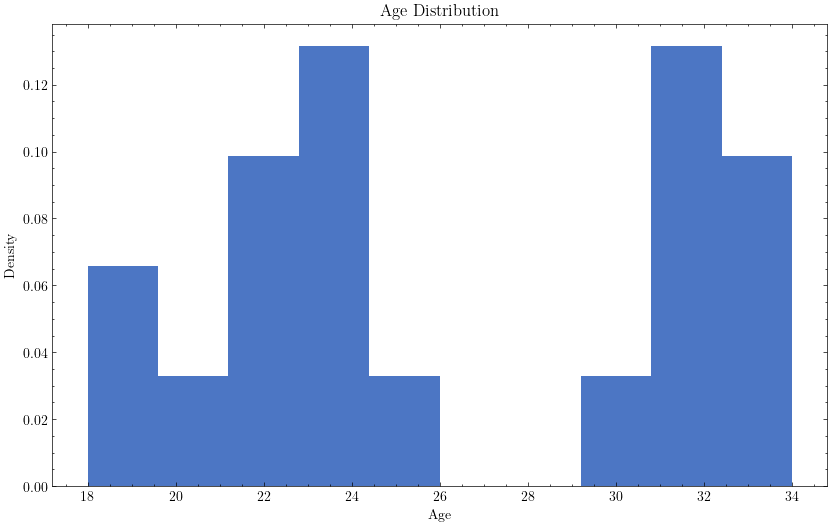

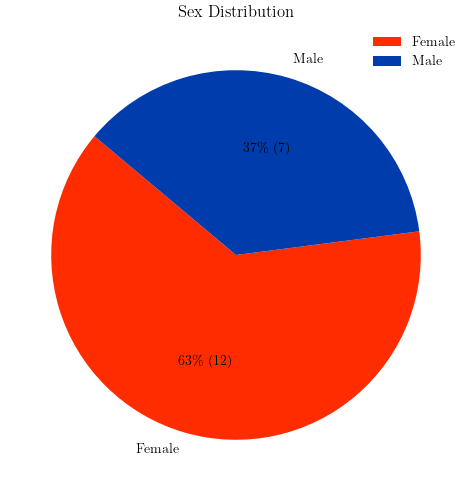

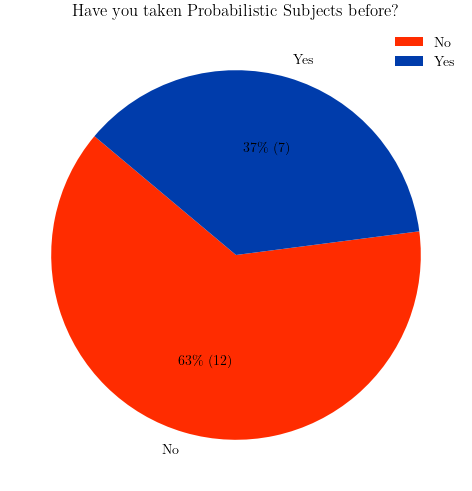

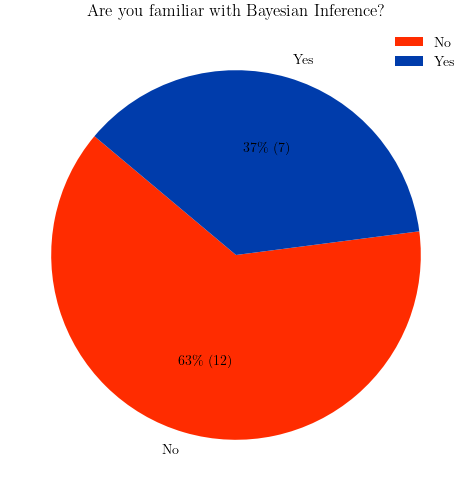

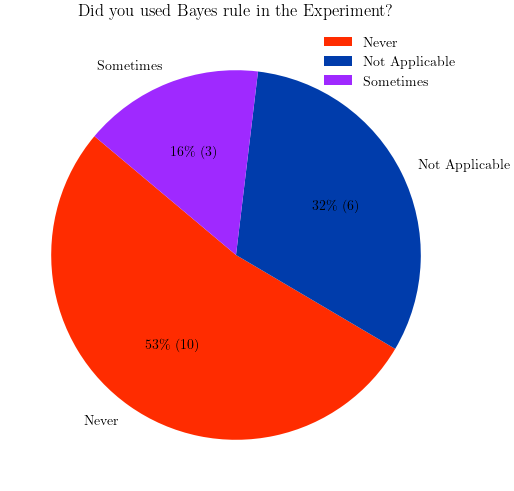

In [78]:
# 'age', 'sex', 'probSubject', 'bayesFamaliar', 'bayesInExp'

histogram(participant_data, 'Age Distribution', 'age', 'Age', bins=10)

pieChart(participant_data,'sex',"Sex Distribution")

pieChart(participant_data,'probSubject',"Have you taken Probabilistic Subjects before?")

pieChart(participant_data,'bayesFamaliar',"Are you familiar with Bayesian Inference?")

pieChart(participant_data,'bayesInExp',"Did you used Bayes rule in the Experiment?")


## Disaggregate according to Each Ball Draw in Each Instance (Average the Performance of each individual)

In [79]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c'],
      dtype='object')

In [85]:
urnColumns = ['instanceName','seqBall','DQ_U_o', 'urns', 'colours', 'responseTimeUrn','CC_u','DQ_U_o','DQ_U_s','EWCC_u','MDCC_u','ACC_u','AEWCC_u','AMDCC_u'] 

ins_seq_grouped_mean_urn = participant_data[urnColumns].groupby(['instanceName','seqBall']).mean()
ins_seq_grouped_mean_urn

DQ_U_o  urns  colours  responseTimeUrn  CC_u  DQ_U_o  \
instanceName seqBall                                                         
1            1          0.97  2.00     2.00            21.97  5.00    0.97   
             2          0.93  2.00     2.00            20.19 10.00    0.93   
             3          0.94  2.00     2.00            19.80 10.00    0.94   
3            1          0.94  2.00     3.00            34.78  5.00    0.94   
             2          0.81  2.00     3.00            86.24 10.00    0.81   
             3          0.77  2.00     3.00            45.37 10.00    0.77   
5            1          0.98  2.00     4.00            36.96  5.00    0.98   
             2          0.85  2.00     4.00            23.19 10.00    0.85   
             3          0.78  2.00     4.00            20.65 10.00    0.78   
7            1          0.94  3.00     2.00            81.52 10.00    0.94   
             2          0.90  3.00     2.00           105.77 18.00    0.90   
             3          0.88  3.00     2.00            64.81 18.00    0.88   
9            1          0.94  3.00     3.00            29.89 10.00    0.94   
             2          0.77  3.00     3.00            23.62 18.00    0.77   
             3          0.68  3.00     3.00            28.11 18.00    0.68   
11           1          0.97  3.00     4.00            48.76 10.00    0.97   
             2          0.88  3.00     4.00            34.37 18.00    0.88   
             3          0.80  3.00     4.00            28.30 18.00    0.80   
12           1          0.95  3.00     4.00            59.66 10.00    0.95   
             2          0.89  3.00     4.00            49.55 18.00    0.89   
             3          0.82  3.00     4.00            62.56 18.00    0.82   
13           1          0.95  4.00     2.00            80.99 15.00    0.95   
             2          0.88  4.00     2.00            76.03 26.00    0.88   
             3          0.91  4.00     2.00            76.76 26.00    0.91   
15           1          0.91  4.00     3.00           103.38 15.00    0.91   
             2          0.79  4.00     3.00            59.11 26.00    0.79   
             3          0.82  4.00     3.00            48.97 26.00    0.82   
16           1          0.92  4.00     3.00           116.53 15.00    0.92   
             2          0.81  4.00     3.00            72.98 26.00    0.81   
             3          0.71  4.00     3.00            56.87 26.00    0.71   
17           1          0.97  4.00     4.00            43.61 15.00    0.97   
             2          0.84  4.00     4.00            71.24 26.00    0.84   
             3          0.81  4.00     4.00            60.04 26.00    0.81   
18           1          0.96  4.00     4.00            60.13 15.00    0.96   
             2          0.83  4.00     4.00            44.68 26.00    0.83   
             3          0.78  4.00     4.00            45.26 26.00    0.78   

                      DQ_U_s  EWCC_u  MDCC_u  ACC_u  AEWCC_u  AMDCC_u  
instanceName seqBall                                                   
1            1          0.97    3.00    2.00   5.00     3.00     2.00  
             2          0.91    6.00    4.00  15.00     9.00     6.00  
             3          0.89    6.00    4.00  25.00    15.00    10.00  
3            1          0.94    3.00    2.00   5.00     3.00     2.00  
             2          0.83    6.00    4.00  15.00     9.00     6.00  
             3          0.85    6.00    4.00  25.00    15.00    10.00  
5            1          0.98    3.00    2.00   5.00     3.00     2.00  
             2          0.87    6.00    4.00  15.00     9.00     6.00  
             3          0.86    6.00    4.00  25.00    15.00    10.00  
7            1          0.94    6.00    4.00  10.00     6.00     4.00  
             2          0.91   11.00    7.00  28.00    17.00    11.00  
             3          0.88   11.00    7.00  46.00    28.00    18.00  
9            1          0.94    6.00    4.00  10.

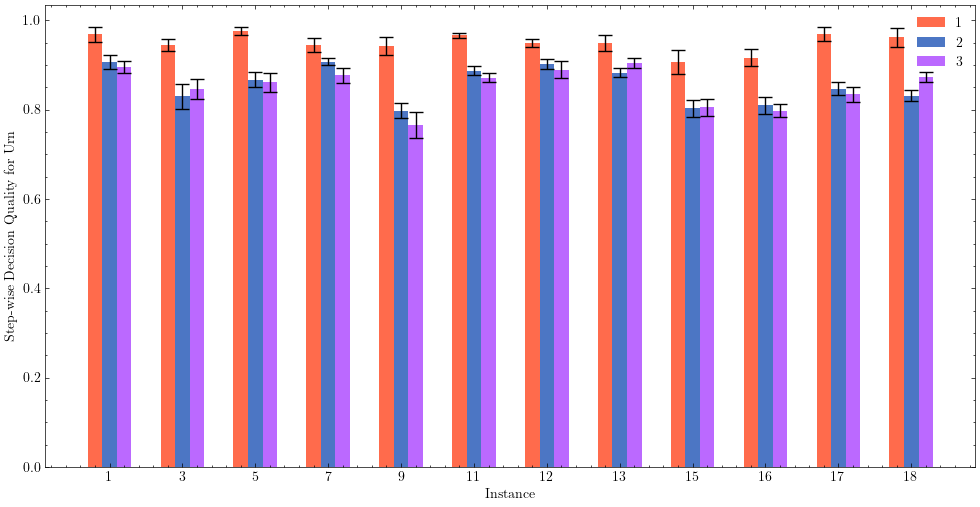

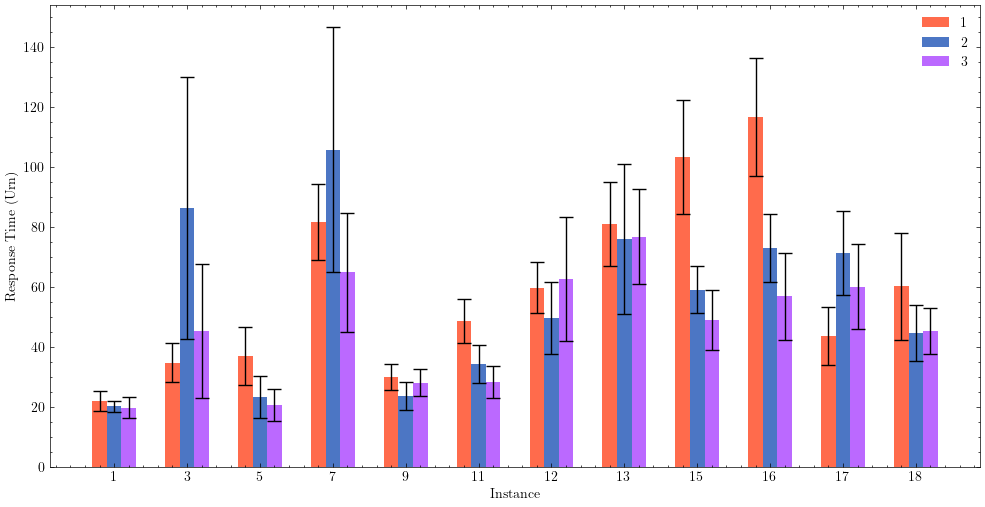

In [84]:
threeAttributes_bar(df=participant_data, lengend_var='seqBall', y_name='DQ_U_s', y_label='Step-wise Decision Quality for Urn', x_name='instanceName', x_label='Instance', out=False)
threeAttributes_bar(df=participant_data, lengend_var='seqBall', y_name='responseTimeUrn', y_label='Response Time (Urn)', x_name='instanceName', x_label='Instance', out=False)

## Disaggregate According to Complexity

### Computational Complexity of each Instance

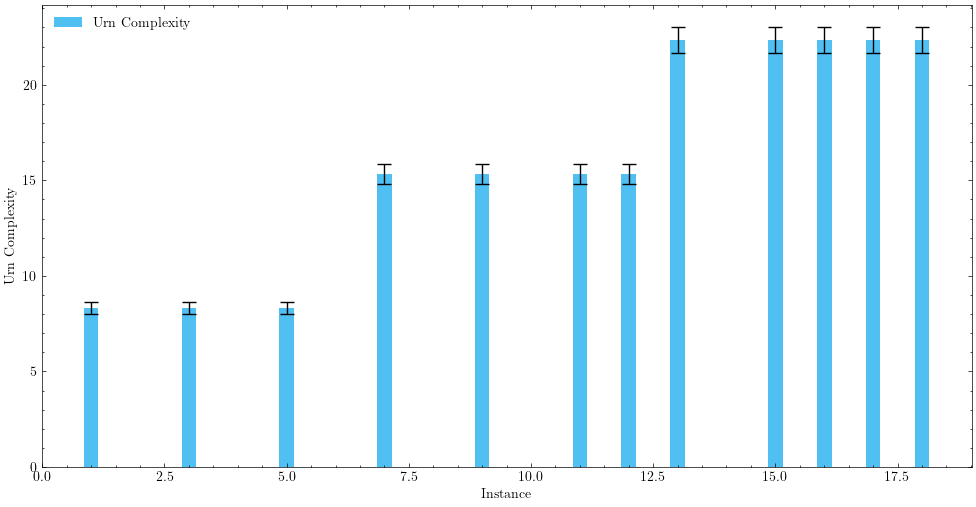

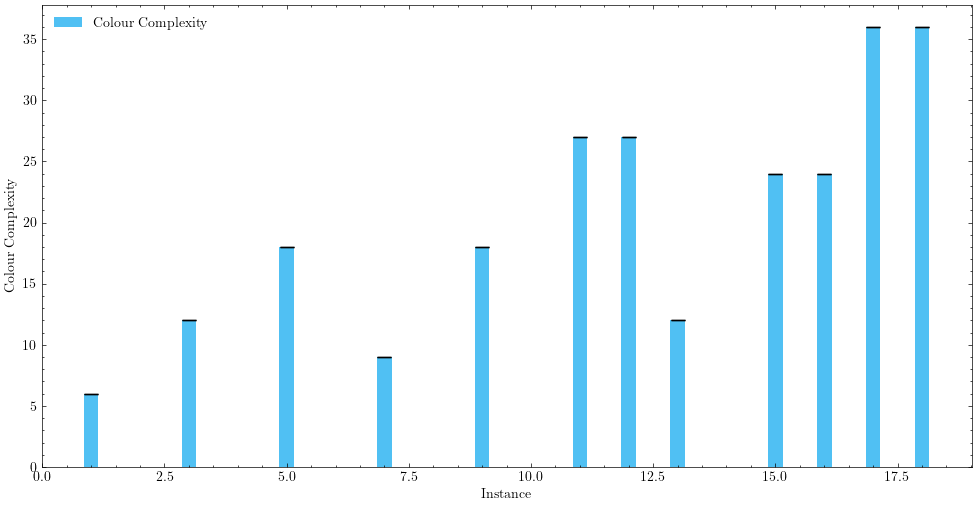

In [86]:
twoAttributes_bar(participant_data, y_name='CC_u', y_label='Urn Complexity ', x_name='instanceName', x_label='Instance', out=False)
twoAttributes_bar(participant_data, y_name='CC_c', y_label='Colour Complexity ', x_name='instanceName', x_label='Instance', out=False)

### Decision Quality Vs Complexity

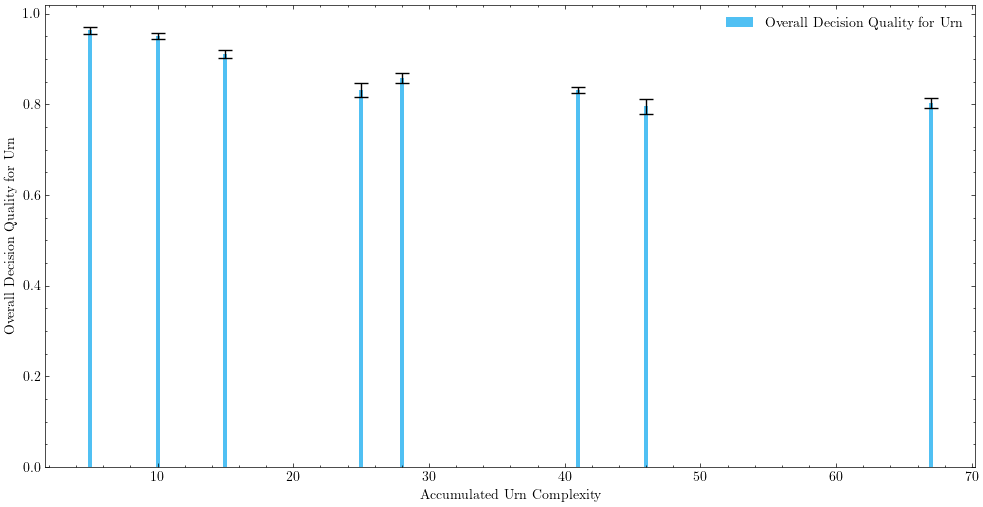

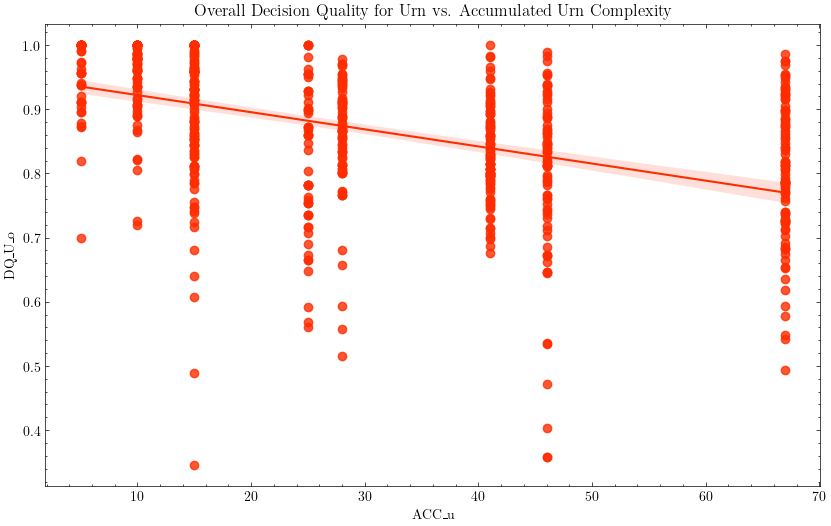

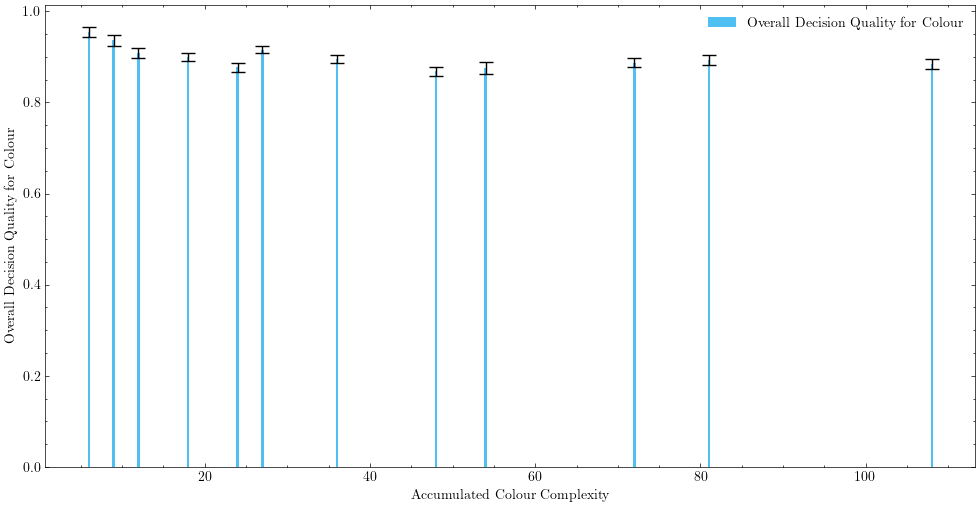

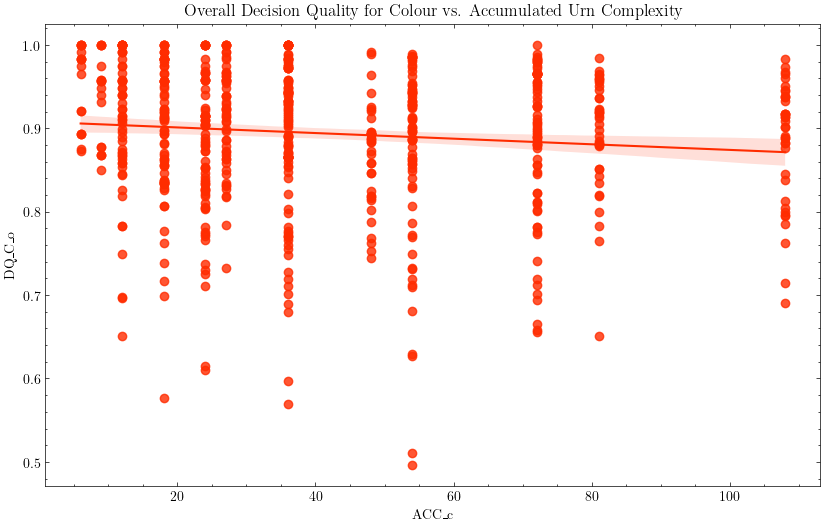

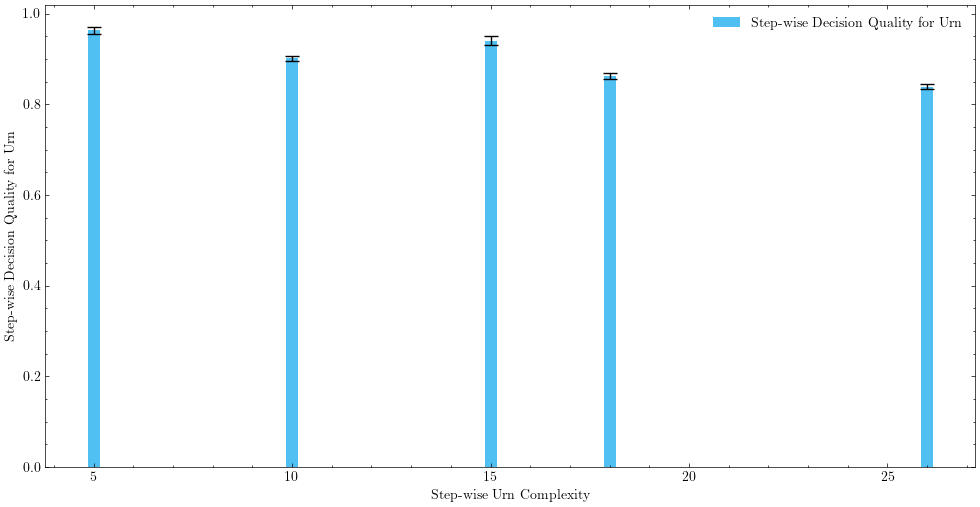

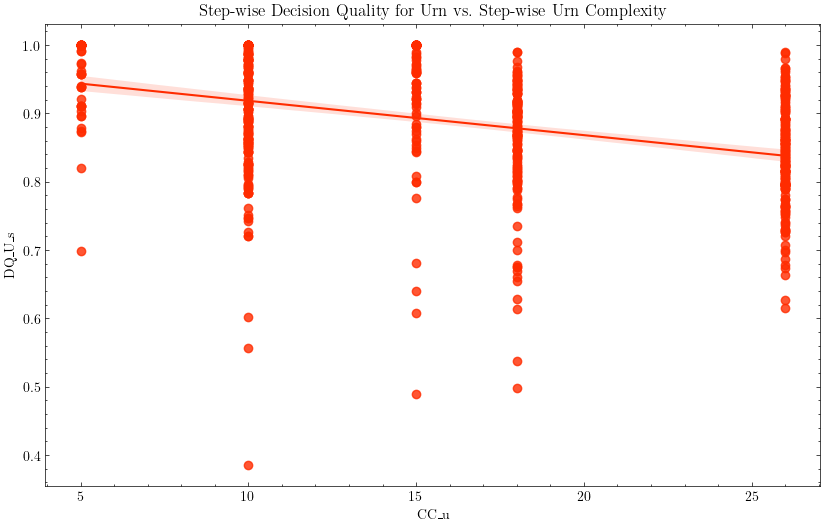

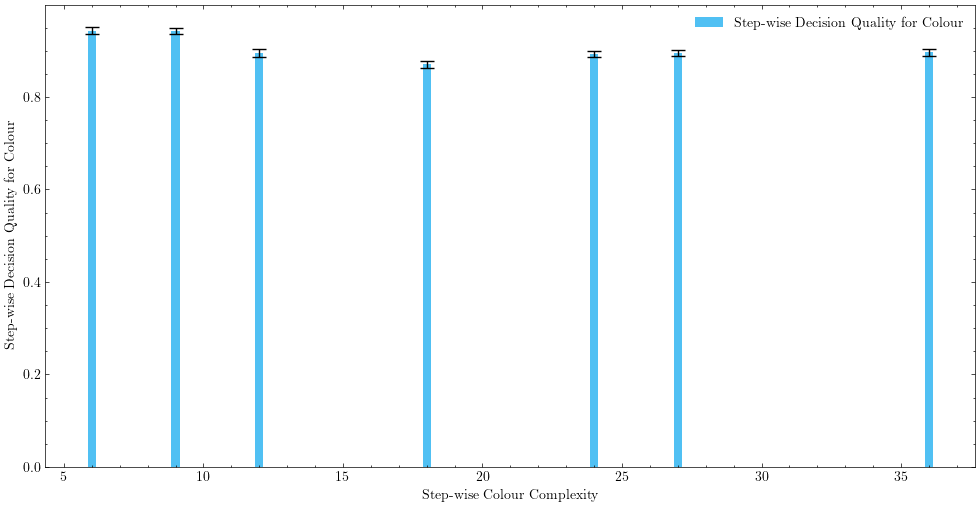

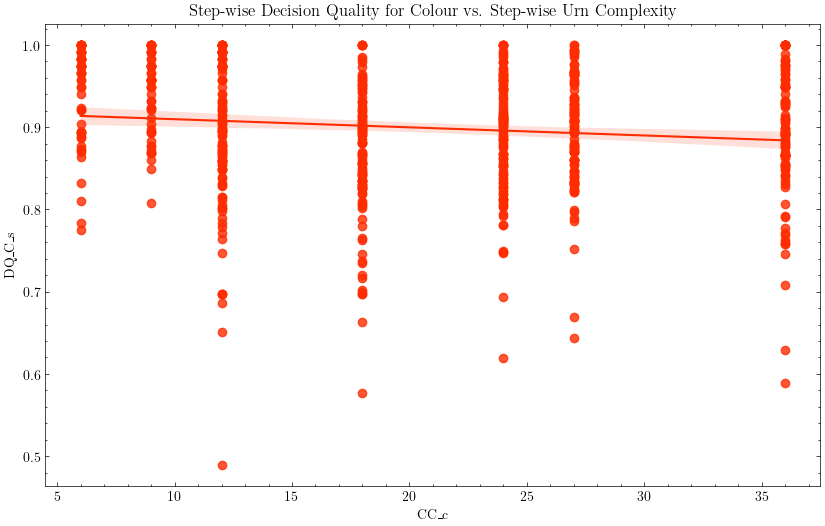

In [92]:
twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Overall Decision Quality for Urn', x_name='ACC_u', x_label='Accumulated Urn Complexity', out=False)
regPlot(participant_data, x_name='ACC_u', y_name='DQ_U_o', title='Overall Decision Quality for Urn vs. Accumulated Urn Complexity')
twoAttributes_bar(participant_data, y_name='DQ_C_o', y_label='Overall Decision Quality for Colour', x_name='ACC_c', x_label='Accumulated Colour Complexity', out=False)
regPlot(participant_data, x_name='ACC_c', y_name='DQ_C_o', title='Overall Decision Quality for Colour vs. Accumulated Urn Complexity')

twoAttributes_bar(participant_data, y_name='DQ_U_s', y_label='Step-wise Decision Quality for Urn', x_name='CC_u', x_label='Step-wise Urn Complexity', out=False)
regPlot(participant_data, x_name='CC_u', y_name='DQ_U_s', title='Step-wise Decision Quality for Urn vs. Step-wise Urn Complexity')
twoAttributes_bar(participant_data, y_name='DQ_C_s', y_label='Step-wise Decision Quality for Colour', x_name='CC_c', x_label='Step-wise Colour Complexity', out=False)
regPlot(participant_data, x_name='CC_c', y_name='DQ_C_s', title='Step-wise Decision Quality for Colour vs. Step-wise Urn Complexity')

### Response Time Vs Complexity

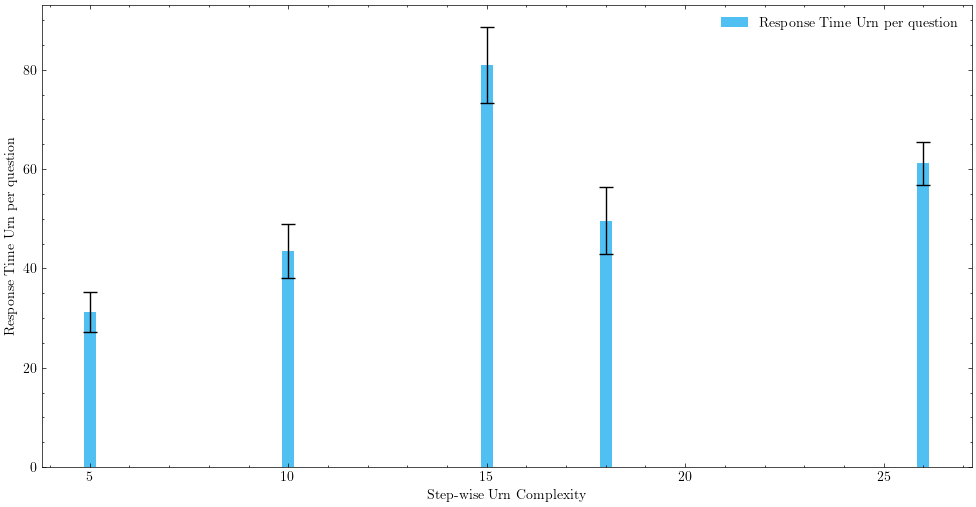

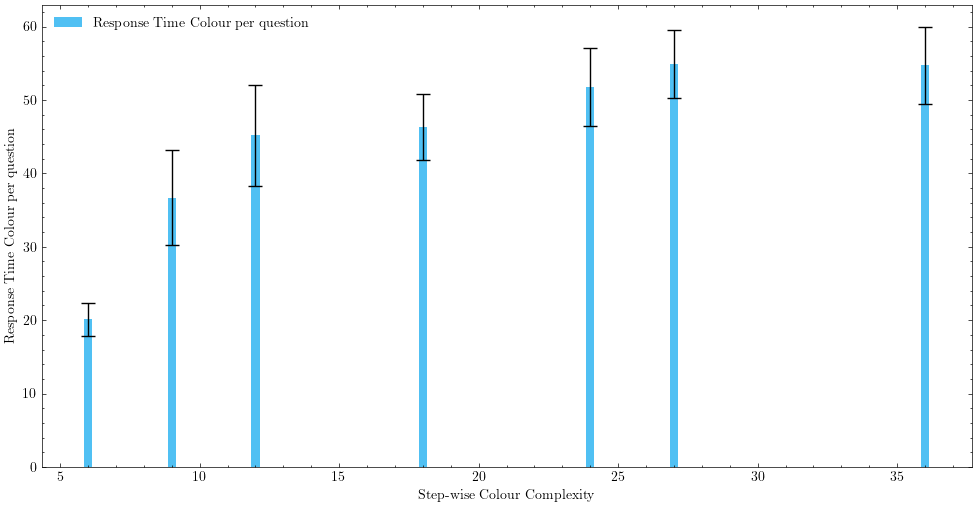

In [93]:
twoAttributes_bar(participant_data, y_name='responseTimeUrn', y_label='Response Time Urn per question', x_name='CC_u', x_label='Step-wise Urn Complexity ', out=False)
twoAttributes_bar(participant_data, y_name='responseTimeColour', y_label='Response Time Colour per question', x_name='CC_c', x_label='Step-wise Colour Complexity ', out=False)

## Pool Urn Decision Quality and Complexity together

In [ ]:
# urnColumns = ['participantID', 'instanceName', 'responseTimeUrn', 'DQ_U_o', 'CC_u']
# colColumns = ['participantID', 'instanceName', 'responseTimeColour', 'DQ_C_o', 'CC_c']


# urn_df = participant_data[urnColumns]
# col_df = participant_data[colColumns]

# urn_df['questionType'] = 'Urn'
# col_df['questionType'] = 'Colour'

# urnColumnNameMappings = {'responseTimeUrn': 'responseTime', 
#                          'JSD_Urn': 'JSD',
#                          'urn_complexity_weighted': 'complexityWeighted',
#                          'urn_complexity_MD': 'complexityMD',
#                          'urn_complexity_total': 'complexityTotal'}

# colColumnNameMappings = {'responseTimeColour': 'responseTime',
#                             'JSD_Col': 'JSD',
#                             'col_complexity_weighted': 'complexityWeighted',
#                             'col_complexity_MD': 'complexityMD',
#                             'col_complexity_total': 'complexityTotal'}

# merged_df = pd.concat([urn_df.rename(columns= urnColumnNameMappings), 
#                        col_df.rename(columns= colColumnNameMappings)], 
#                       ignore_index=True)



## Basic Information

In [ ]:
# def qualityHistogram(df, title, x_name, x_label):
#     '''
#     Inputs: 
#     df is the input dataframe
#     x_name is the column name of the data to be plotted
#     x_label is the label for the x-axis
#     Ouputs: 
#     Histogram of the data
#     '''
#     with plt.style.context("science"):
#         plt.figure(figsize=(10, 6), dpi=100)
#         plt.hist(df[x_name], bins=10, range=(0,1), color=COLORS[1], edgecolor=COLORS[1], alpha=0.7)
#         plt.title(title)
#         plt.xlabel(x_label)
#         plt.ylabel('Frequency')
#         plt.xlim(0, 1)
#         plt.show()



In [ ]:
# qualityHistogram(participant_data, 'Histogram of JSD Urn', 'DQ_U_o', 'Decision Quality Urn')
# qualityHistogram(participant_data, 'Histogram of JSD Col', 'DQ_C_o', 'Decision Quality Colour')


# Regressions

## Bayesian Regressions

### H1-B In the state updating question, decision quality does not decrease as the number of potential signals (number of possible colors) in an instance increase, since more potential signals does not increase computational complexity.

In [ ]:
participant_data.columns

### H2-C In state updating task, step-wise decision quality for the third ball draw is no lower than for the second ball draw, as the belief updating process of the third and second draws have the same computational complexity.

### H4 In signal prediction task, the step-wise decision quality for the third ball draw is no lower than for the second ball draw and the first ball draw, as the belief updating process of the third draw has the same computational complexity with for the second draw and the first ball draw.

### H1 In the question regarding the hidden state of the world (the state updating task), decision quality is predicted to be negatively correlated with computational complexity.

### H2 In state updating task, step-wise decision quality (decision quality taking into account participants previous answers as priors of the next updating) is negatively correlated with step-wise computational complexity.

## Frequentist Models

In [94]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c'],
      dtype='object')

In [102]:
# R1
model = mixedlm("DQ_U_o ~ ACC_u", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_U_o  
No. Observations: 684     Method:             REML    
No. Groups:       19      Scale:              0.0097  
Min. group size:  36      Log-Likelihood:     594.7027
Max. group size:  36      Converged:          Yes     
Mean group size:  36.0                                
------------------------------------------------------
           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   0.949    0.009 109.983 0.000  0.932  0.966
ACC_u      -0.003    0.000 -13.891 0.000 -0.003 -0.002
Group Var   0.001    0.003                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [103]:
# R2
model = mixedlm("DQ_C_o ~ ACC_c", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_C_o  
No. Observations: 684     Method:             REML    
No. Groups:       19      Scale:              0.0058  
Min. group size:  36      Log-Likelihood:     757.8563
Max. group size:  36      Converged:          No      
Mean group size:  36.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.908    0.010 89.522 0.000  0.888  0.928
ACC_c       -0.000    0.000 -3.082 0.002 -0.001 -0.000
Group Var    0.001    0.008                           



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 2.502494
  warnings.warn(msg, ConvergenceWarning)
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [98]:
# R3
model = mixedlm("DQ_U_o ~ urns + colours + seqBall", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_U_o  
No. Observations: 684     Method:             REML    
No. Groups:       19      Scale:              0.0088  
Min. group size:  36      Log-Likelihood:     622.9736
Max. group size:  36      Converged:          Yes     
Mean group size:  36.0                                
------------------------------------------------------
           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   1.100    0.022  49.806 0.000  1.057  1.143
urns       -0.012    0.004  -2.581 0.010 -0.020 -0.003
colours    -0.017    0.004  -3.721 0.000 -0.026 -0.008
seqBall    -0.071    0.004 -16.198 0.000 -0.080 -0.062
Group Var   0.001    0.003                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [100]:
# R4
model = mixedlm("DQ_C_o ~ urns + colours + seqBall", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_C_o  
No. Observations: 684     Method:             REML    
No. Groups:       19      Scale:              0.0058  
Min. group size:  36      Log-Likelihood:     758.0625
Max. group size:  36      Converged:          No      
Mean group size:  36.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.941    0.019 49.699 0.000  0.904  0.979
urns         0.004    0.004  1.190 0.234 -0.003  0.011
colours     -0.016    0.004 -4.333 0.000 -0.023 -0.009
seqBall     -0.006    0.004 -1.603 0.109 -0.013  0.001
Group Var    0.001    0.005                           



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 5.724427
  warnings.warn(msg, ConvergenceWarning)
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [101]:
# R5
model = mixedlm("DQ_U_s ~ CC_u", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_U_s  
No. Observations: 684     Method:             REML    
No. Groups:       19      Scale:              0.0068  
Min. group size:  36      Log-Likelihood:     715.4464
Max. group size:  36      Converged:          Yes     
Mean group size:  36.0                                
------------------------------------------------------
           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   0.969    0.009 103.249 0.000  0.950  0.987
CC_u       -0.005    0.000 -11.124 0.000 -0.006 -0.004
Group Var   0.000    0.003                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [104]:
# R6
model = mixedlm("DQ_C_s ~ CC_c", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_C_s  
No. Observations: 684     Method:             REML    
No. Groups:       19      Scale:              0.0047  
Min. group size:  36      Log-Likelihood:     830.5537
Max. group size:  36      Converged:          Yes     
Mean group size:  36.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.920    0.010 92.288 0.000  0.900  0.939
CC_c        -0.001    0.000 -3.594 0.000 -0.002 -0.000
Group Var    0.001    0.006                           



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [105]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c'],
      dtype='object')

In [106]:
# R7
model = mixedlm("DQ_U_o ~ probSubject + bayesInExp", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      DQ_U_o  
No. Observations:        684          Method:                  REML    
No. Groups:              19           Scale:                   0.0125  
Min. group size:         36           Log-Likelihood:          508.1383
Max. group size:         36           Converged:               Yes     
Mean group size:         36.0                                          
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.870    0.010 83.214 0.000  0.849  0.890
probSubject[T.Yes]           -0.001    0.015 -0.078 0.938 -0.030  0.028
bayesInExp[T.Not Applicable] -0.008    0.015 -0.490 0.624 -0.038  0.023
bayesInExp[T.Sometimes]       0.009    0.020  0.440 0.660 -0.031  0.049
Group Var

/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [107]:
# R8
model = mixedlm("DQ_C_o ~ probSubject + bayesInExp", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      DQ_C_o  
No. Observations:        684          Method:                  REML    
No. Groups:              19           Scale:                   0.0059  
Min. group size:         36           Log-Likelihood:          753.1440
Max. group size:         36           Converged:               Yes     
Mean group size:         36.0                                          
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.889    0.014 63.308 0.000  0.861  0.916
probSubject[T.Yes]           -0.008    0.020 -0.397 0.691 -0.047  0.031
bayesInExp[T.Not Applicable]  0.020    0.021  0.972 0.331 -0.021  0.061
bayesInExp[T.Sometimes]       0.010    0.027  0.354 0.723 -0.044  0.064
Group Var

/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [114]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3'],
      dtype='object')

In [115]:
# R9
model = mixedlm("DQ_U_s ~ DV_seqBall_1 + DV_seqBall_3", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: DQ_U_s  
No. Observations:   684     Method:             REML    
No. Groups:         19      Scale:              0.0060  
Min. group size:    36      Log-Likelihood:     757.4451
Max. group size:    36      Converged:          Yes     
Mean group size:    36.0                                
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.856    0.007 121.201 0.000  0.842  0.870
DV_seqBall_1  0.093    0.007  12.909 0.000  0.079  0.108
DV_seqBall_3 -0.004    0.007  -0.609 0.542 -0.019  0.010
Group Var     0.000    0.003                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [116]:
# R10
model = mixedlm("DQ_U_s ~ DV_seqBall_2 + DV_seqBall_3", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: DQ_U_s  
No. Observations:   684     Method:             REML    
No. Groups:         19      Scale:              0.0060  
Min. group size:    36      Log-Likelihood:     757.4451
Max. group size:    36      Converged:          Yes     
Mean group size:    36.0                                
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.949    0.007 134.429 0.000  0.936  0.963
DV_seqBall_2 -0.093    0.007 -12.909 0.000 -0.108 -0.079
DV_seqBall_3 -0.098    0.007 -13.518 0.000 -0.112 -0.084
Group Var     0.000    0.003                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Other Things

In [ ]:
import time

start_time = time.time()
for i in range(100000000):
    result = 0.25 * 0.33
end_time = time.time()

time_consumed = end_time - start_time
print(f"Time consumed for calculating: {time_consumed} seconds")

In [ ]:
import time

start_time = time.time()
result = 0
for i in range(100000000):
    result = 0.25 + 0.33
end_time = time.time()

time_consumed = end_time - start_time
print(f"Time consumed for calculating: {time_consumed} seconds")